# Data Cleaning

In [1]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version
import warnings;   warnings.filterwarnings("ignore")

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.10"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.10"):
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.22.4", 'matplotlib': "3.5.2",'sklearn': "1.1.1", 
                'pandas': "1.4.2",'xgboost': "1.5.1", 'shap': "0.40.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.10.5

[ OK ] numpy version 1.22.4 is installed.
[ OK ] matplotlib version 3.5.2 is installed.
[ OK ] sklearn version 1.1.1 is installed.
[ OK ] pandas version 1.4.2 is installed.
[ OK ] xgboost version 1.5.1 is installed.
[ OK ] shap version 0.40.0 is installed.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from itertools import accumulate
import six
nan = np.nan

fantasy_21_raw = pd.read_csv ('../data/fantasy_21.csv')
fantasy_22_raw = pd.read_csv ('../data/fantasy_22.csv')
teams_fifa_21_raw = pd.read_csv ('../data/teams_fifa22.csv')
teams_fifa_22_raw = pd.read_csv ('../data/teams_fifa23.csv')
matches_21_raw = pd.read_csv ('../data/matches_21.csv')
matches_22_raw = pd.read_csv ('../data/matches_22.csv')

In [3]:
#creates matches_21 dataset (contains all matches from 2021 season)
matches_21 = matches_21_raw[["Date", "Time","HomeTeam", "AwayTeam", "FTR", "Referee", "B365H", "B365D", "B365A"]]
matches_21 = matches_21.assign(HICT="")
matches_21 = matches_21.assign(AICT="")
matches_21.sort_index(inplace=True)
matches_21 = matches_21.reset_index(drop=True)

In [4]:
#creates fifa 21 dataset
fifa_21 = teams_fifa_21_raw[['Name','Overall']]
fifa_21 = fifa_21.head(20)
fifa_21 = fifa_21.sort_values(['Name'])
fifa_21['Overall'] = fifa_21['Overall'].apply(lambda x: x*100)

#creates list of overall team scores 
overall_21_away = fifa_21.Overall.to_list()
overall_21_home = fifa_21.Overall.to_list()

In [5]:
#creates fifa 22 dataset
fifa_22 = teams_fifa_22_raw[['Name','Overall']]
fifa_22 = fifa_22.head(21)
fifa_22 = fifa_22[fifa_22.Name != 'AFC Richmond'].reset_index(drop = True)
fifa_22 = fifa_22.replace('AFC Bournemouth', 'Bournemouth')
fifa_22 = fifa_22.sort_values(['Name'])
fifa_22['Overall'] = fifa_22['Overall'].apply(lambda x: x*100)

#creates list of overall team scores 
overall_22_away = fifa_22.Overall.to_list()
overall_22_home = fifa_22.Overall.to_list()

In [6]:
#creates matches_22 dataset (contains all matches from 2022 season)
matches_22 = matches_22_raw[["Date", "GW","HomeTeam", "AwayTeam", "FTR", "Referee", "B365H", "B365D", "B365A"]]
matches_22 = matches_22.assign(HICT="")
matches_22 = matches_22.assign(AICT="")
matches_22.sort_index(inplace=True)
matches_22 = matches_22.reset_index(drop=True)

In [7]:
#creates ICT score dataset for 2021 season
fantasy_21_raw[['Date', 'Time']] = fantasy_21_raw['kickoff_time'].str.split('T', 1, expand=True)
fantasy_21 = fantasy_21_raw[["team", "ict_index", "Date", 'minutes']] 
fantasy_21 = fantasy_21.sort_values(by=['team', 'Date'])
fantasy_21 = fantasy_21.groupby(by=['team', 'Date'])['ict_index'].sum().to_frame()
ICT_2021 = fantasy_21.pivot_table(index=['team'], 
            columns=['Date'], values='ict_index').fillna(0)
ICT_2021.sort_index(inplace=True)
ICT_2021.reset_index(inplace=True)

In [8]:
#creates ICT score dataset for 2022 season
fantasy_22 = fantasy_22_raw[["team", "ict_index", "GW", 'minutes']]  
fantasy_22 = fantasy_22.sort_values(by=['team', 'GW'])
fantasy_22 = fantasy_22.groupby(by=['team', 'GW'])['ict_index'].sum().to_frame()
ICT_2022 = fantasy_22.pivot_table(index=['team'], 
            columns=['GW'], values='ict_index').fillna(0)
ICT_2022.sort_index(inplace=True)
ICT_2022.reset_index(inplace=True)

In [9]:
#creates boolean dataset showing when each team was home for 2021 season
fantasy_21 = fantasy_21_raw[["team", "was_home", "Date"]]
fantasy_21 = fantasy_21.sort_values(by=['team', 'Date'])
WH_2021 = fantasy_21.pivot_table(index=['team'], 
            columns=['Date'], values='was_home').fillna(0)
WH_2021.sort_index(inplace=True)
WH_2021.reset_index(inplace=True)

In [10]:
#creates boolean dataset showing when each team was home for 2022 season
fantasy_22 = fantasy_22_raw[["team", "was_home", "GW"]]
fantasy_22 = fantasy_22.sort_values(by=['team', 'GW'])
WH_2022 = fantasy_22.pivot_table(index=['team'], 
            columns=['GW'], values='was_home').fillna(0)
WH_2022.sort_index(inplace=True)
WH_2022.reset_index(inplace=True)

In [11]:
#helper funtions

#returns average of list
def Average(lst):
    return sum(lst) / len(lst)

#returns scores of each team
def get_score_21_away():
    empty_list_21 = []
    for score in overall_21_away:
        if score not in empty_list_21:
            empty_list_21.append(score)
            overall_21_away.remove(score)
            return score

def get_score_22_away():
    empty_list_22 = []
    for score in overall_22_away:
        if score not in empty_list_22:
            empty_list_22.append(score)
            overall_22_away.remove(score)
            return score
        
def get_score_21_home():
    empty_list_21 = []
    for score in overall_21_home:
        if score not in empty_list_21:
            empty_list_21.append(score)
            overall_21_home.remove(score)
            return score

def get_score_22_home():
    empty_list_22 = []
    for score in overall_22_home:
        if score not in empty_list_22:
            empty_list_22.append(score)
            overall_22_home.remove(score)
            return score

In [12]:
#sorts matches 21 dataset by date and awayteam and converts to datetime object
matches_21['Date'] = pd.to_datetime(matches_21['Date'], format='%m/%d/%y')
matches_21 = matches_21.sort_values(['AwayTeam','Date']).reset_index(drop=True)

#combines matches 21 with a mask of boolean was home dataset (away)
away_team_ict_21 = ICT_2021.mask(WH_2021 == 1.0)

#populates AICT column for Matches 21 dataframe
away_team_rows_21 =[]
if 'Away Team' in away_team_ict_21.columns:
    away_team_ict_21 = away_team_ict_21.drop('Away Team', axis=1)  
for index, rows in away_team_ict_21.iterrows():
    my_list = [rows["2021-08-13"],rows["2021-08-14"],rows["2021-08-15"],rows["2021-08-21"],
               rows["2021-08-22"],rows["2021-08-23"],rows["2021-08-28"],rows["2021-08-29"],rows["2021-09-11"],
               rows["2021-09-12"],rows["2021-09-13"],rows["2021-09-17"],rows["2021-09-18"],rows["2021-09-19"],
               rows["2021-09-25"],rows["2021-09-26"],rows["2021-09-27"],rows["2021-10-02"],rows["2021-10-03"],
               rows["2021-10-16"],rows["2021-10-17"],rows["2021-10-18"],rows["2021-10-22"],rows["2021-10-23"],
               rows["2021-10-24"],rows["2021-10-30"],rows["2021-10-31"],rows["2021-11-01"],rows["2021-11-05"],
               rows["2021-11-06"],rows["2021-11-07"],rows["2021-11-20"],rows["2021-11-21"],rows["2021-11-27"],
               rows["2021-11-28"],rows["2021-11-30"],rows["2021-12-01"],rows["2021-12-02"],rows["2021-12-04"],
               rows["2021-12-05"],rows["2021-12-06"],rows["2021-12-10"],rows["2021-12-11"],rows["2021-12-12"],
               rows["2021-12-14"],rows["2021-12-15"],rows["2021-12-16"],rows["2021-12-18"],rows["2021-12-19"],
               rows["2021-12-26"],rows["2021-12-27"],rows["2021-12-28"],rows["2021-12-29"],rows["2021-12-30"],
               rows["2022-01-01"],rows["2022-01-02"],rows["2022-01-03"],rows["2022-01-11"],rows["2022-01-12"],
               rows["2022-01-14"],rows["2022-01-15"],rows["2022-01-16"],rows["2022-01-18"],rows["2022-01-19"],
               rows["2022-01-21"],rows["2022-01-22"],rows["2022-01-23"],rows["2022-02-05"],rows["2022-02-08"],
               rows["2022-02-09"],rows["2022-02-10"],rows["2022-02-12"],rows["2022-02-13"],rows["2022-02-15"],
               rows["2022-02-19"],rows["2022-02-20"],rows["2022-02-23"],rows["2022-02-24"],rows["2022-02-25"],
               rows["2022-02-26"],rows["2022-02-27"],rows["2022-03-01"],rows["2022-03-05"],rows["2022-03-06"],
               rows["2022-03-07"],rows["2022-03-10"],rows["2022-03-12"],rows["2022-03-13"],rows["2022-03-14"],
               rows["2022-03-16"],rows["2022-03-17"],rows["2022-03-18"],rows["2022-03-19"],rows["2022-03-20"],
               rows["2022-04-02"],rows["2022-04-03"],rows["2022-04-04"],rows["2022-04-06"],rows["2022-04-08"],
               rows["2022-04-09"],rows["2022-04-10"],rows["2022-04-16"],rows["2022-04-17"],rows["2022-04-19"],
               rows["2022-04-20"],rows["2022-04-21"],rows["2022-04-23"],rows["2022-04-24"],rows["2022-04-25"],
               rows["2022-04-28"],rows["2022-04-30"],rows["2022-05-01"],rows["2022-05-02"],rows["2022-05-07"],
               rows["2022-05-08"],rows["2022-05-10"],rows["2022-05-11"],rows["2022-05-12"],rows["2022-05-15"],
               rows["2022-05-16"],rows["2022-05-17"],rows["2022-05-19"], rows["2022-05-22"]]
    away_team_rows_21.append(my_list)
away_team_rows_21 = [[x for x in y if str(x) != 'nan'] for y in away_team_rows_21]
away_team_rows_21 = [[x for x in y if str(x) != '0.0'] for y in away_team_rows_21]

team_list_sum = []
for team in away_team_rows_21:
    team.insert(0, get_score_21_away())
    team.pop()
    team_list_sum.append(list(accumulate(team)))
flat_list_a21 = []
for sublist in team_list_sum:
    for item in sublist:
        flat_list_a21.append(item)
matches_21 = matches_21.assign(AICT=flat_list_a21)

#combines matches 21 with a mask of boolean was home dataset (home)
home_team_ict_21 = ICT_2021.mask(WH_2021 == 0.0)

#populates HICT column for Matches 21 dataframe
matches_21 = matches_21.sort_values(['HomeTeam','Date']).reset_index(drop=True)
home_team_rows_21 = []
if 'Home Team' in home_team_ict_21.columns:
    home_team_ict_21 = home_team_ict_21.drop('Home Team', axis=1)  
for index, rows in home_team_ict_21.iterrows():
    my_list = [rows["2021-08-13"],rows["2021-08-14"],rows["2021-08-15"],rows["2021-08-21"],
               rows["2021-08-22"],rows["2021-08-23"],rows["2021-08-28"],rows["2021-08-29"],rows["2021-09-11"],
               rows["2021-09-12"],rows["2021-09-13"],rows["2021-09-17"],rows["2021-09-18"],rows["2021-09-19"],
               rows["2021-09-25"],rows["2021-09-26"],rows["2021-09-27"],rows["2021-10-02"],rows["2021-10-03"],
               rows["2021-10-16"],rows["2021-10-17"],rows["2021-10-18"],rows["2021-10-22"],rows["2021-10-23"],
               rows["2021-10-24"],rows["2021-10-30"],rows["2021-10-31"],rows["2021-11-01"],rows["2021-11-05"],
               rows["2021-11-06"],rows["2021-11-07"],rows["2021-11-20"],rows["2021-11-21"],rows["2021-11-27"],
               rows["2021-11-28"],rows["2021-11-30"],rows["2021-12-01"],rows["2021-12-02"],rows["2021-12-04"],
               rows["2021-12-05"],rows["2021-12-06"],rows["2021-12-10"],rows["2021-12-11"],rows["2021-12-12"],
               rows["2021-12-14"],rows["2021-12-15"],rows["2021-12-16"],rows["2021-12-18"],rows["2021-12-19"],
               rows["2021-12-26"],rows["2021-12-27"],rows["2021-12-28"],rows["2021-12-29"],rows["2021-12-30"],
               rows["2022-01-01"],rows["2022-01-02"],rows["2022-01-03"],rows["2022-01-11"],rows["2022-01-12"],
               rows["2022-01-14"],rows["2022-01-15"],rows["2022-01-16"],rows["2022-01-18"],rows["2022-01-19"],
               rows["2022-01-21"],rows["2022-01-22"],rows["2022-01-23"],rows["2022-02-05"],rows["2022-02-08"],
               rows["2022-02-09"],rows["2022-02-10"],rows["2022-02-12"],rows["2022-02-13"],rows["2022-02-15"],
               rows["2022-02-19"],rows["2022-02-20"],rows["2022-02-23"],rows["2022-02-24"],rows["2022-02-25"],
               rows["2022-02-26"],rows["2022-02-27"],rows["2022-03-01"],rows["2022-03-05"],rows["2022-03-06"],
               rows["2022-03-07"],rows["2022-03-10"],rows["2022-03-12"],rows["2022-03-13"],rows["2022-03-14"],
               rows["2022-03-16"],rows["2022-03-17"],rows["2022-03-18"],rows["2022-03-19"],rows["2022-03-20"],
               rows["2022-04-02"],rows["2022-04-03"],rows["2022-04-04"],rows["2022-04-06"],rows["2022-04-08"],
               rows["2022-04-09"],rows["2022-04-10"],rows["2022-04-16"],rows["2022-04-17"],rows["2022-04-19"],
               rows["2022-04-20"],rows["2022-04-21"],rows["2022-04-23"],rows["2022-04-24"],rows["2022-04-25"],
               rows["2022-04-28"],rows["2022-04-30"],rows["2022-05-01"],rows["2022-05-02"],rows["2022-05-07"],
               rows["2022-05-08"],rows["2022-05-10"],rows["2022-05-11"],rows["2022-05-12"],rows["2022-05-15"],
               rows["2022-05-16"],rows["2022-05-17"],rows["2022-05-19"], rows["2022-05-22"]]
    home_team_rows_21.append(my_list)
home_team_rows_21 = [[x for x in y if str(x) != 'nan'] for y in home_team_rows_21]
home_team_rows_21 = [[x for x in y if str(x) != '0.0'] for y in home_team_rows_21]

team_list_sum = []
for team in home_team_rows_21:
    team.insert(0, get_score_21_home())
    team.pop()
    team_list_sum.append(list(accumulate(team)))

flat_list_h21 = []
for sublist in team_list_sum:
    for item in sublist:
        flat_list_h21.append(item)
matches_21 = matches_21.assign(HICT=flat_list_h21)

In [13]:
#sorts matches 22 dataset by date and converts to datetime object
matches_22['Date'] = pd.to_datetime(matches_22['Date'], format='%m/%d/%y')
matches_22 = matches_22.sort_values(['AwayTeam','Date']).reset_index(drop=True)

#combines matches 22 with a mask of boolean was home dataset (away)
away_team_ict_22 = ICT_2022.mask(WH_2022 == 1.0)
away_team_ict_22 = away_team_ict_22.rename({'team': 'Away Team', 1: 'GW1', 2: 'GW2', 3: 'GW3', 4: 'GW4', 
                            5: 'GW5', 6: 'GW6', 8: 'GW8', 9: 'GW9', 10: 'GW10'}, axis=1)

#populates AICT column for Matches 22 dataframe
away_team_rows_22 =[]
if 'Away Team' in away_team_ict_22.columns:
    away_team_ict_22 = away_team_ict_22.drop('Away Team', axis=1)  

for index, rows in away_team_ict_22.iterrows():
    my_list =[rows.GW1, rows.GW2, rows.GW3, rows.GW4, 
              rows.GW5, rows.GW6, rows.GW8, rows.GW9, rows.GW10]
    away_team_rows_22.append(my_list)

away_team_rows_22 = [[x for x in y if str(x) != 'nan'] for y in away_team_rows_22]
away_team_rows_22 = [[x for x in y if str(x) != '0.0'] for y in away_team_rows_22]


team_list_sum = []
for team in away_team_rows_22:
    team.insert(0, get_score_22_away())
    team.pop()
    team_list_sum.append(list(accumulate(team)))

flat_list_a22 = []
for sublist in team_list_sum:
    for item in sublist:
        flat_list_a22.append(item)
matches_22 = matches_22.assign(AICT=flat_list_a22)

#combines matches 22 with a mask of boolean was home dataset (home)
home_team_ict_22 = ICT_2022.mask(WH_2022 == 0.0)
home_team_ict_22 = home_team_ict_22.rename({'team': 'Home Team', 1: 'GW1', 2: 'GW2', 3: 'GW3', 4: 'GW4', 
                            5: 'GW5', 6: 'GW6', 8: 'GW8', 9: 'GW9', 10: 'GW10'}, axis=1) 

#populates HICT column for Matches 22 dataframe
matches_22 = matches_22.sort_values(['HomeTeam','Date'])
home_team_rows_22 =[]
if 'Home Team' in home_team_ict_22.columns:
    home_team_ict_22.drop('Home Team', axis=1)  
for index, rows in home_team_ict_22.iterrows():
    my_list =[rows.GW1, rows.GW2, rows.GW3, rows.GW4, 
              rows.GW5, rows.GW6, rows.GW8, rows.GW9, rows.GW10]
    home_team_rows_22.append(my_list)
home_team_rows_22 = [[x for x in y if str(x) != 'nan'] for y in home_team_rows_22]
home_team_rows_22 = [[x for x in y if str(x) != '0.0'] for y in home_team_rows_22]

team_list_sum = []
for team in home_team_rows_22:
    team.insert(0, get_score_22_home())
    team.pop()
    team_list_sum.append(list(accumulate(team)))

flat_list_h22 = []
for sublist in team_list_sum:
    for item in sublist:
        flat_list_h22.append(item)
matches_22 = matches_22.assign(HICT=flat_list_h22)

In [14]:
#creates final dataset with cleaned data
#final_dataset = matches_21.append(matches_22).reset_index(drop = 'TRUE')
final_dataset = pd.concat([matches_21, matches_22]) 

final_dataset = final_dataset.sort_values(by='Date').reset_index(drop=True)
final_dataset = final_dataset.drop(['Time','GW'], axis=1)
final_dataset['DifICT'] = (final_dataset['HICT'] - final_dataset['AICT'])

if 'FTR' in final_dataset.columns:
    final_dataset['Result']=final_dataset['FTR']
    final_dataset = final_dataset.drop('FTR', axis=1)
    
#converts target variable to nominal data
final_dataset['Result'] = final_dataset['Result'].astype('category')
final_dataset['Result'].cat.categories = [0,1,2]
final_dataset['Result'] = final_dataset['Result'].astype('float')
date = final_dataset.copy()
if 'Date' in final_dataset.columns:
   final_dataset = final_dataset.drop('Date', axis=1)


ref_impact = final_dataset

if 'HomeTeam' in final_dataset.columns:
   final_dataset = final_dataset.drop('HomeTeam', axis=1)

if 'AwayTeam' in final_dataset.columns:
   final_dataset = final_dataset.drop('AwayTeam', axis=1)

final_dataset

,Referee,B365H,B365D,B365A,HICT,AICT,DifICT,Result
0,M Oliver,4.00,3.40,1.95,7300.0,7900.0,-600.0,2.0
1,A Madley,1.90,3.50,4.00,7900.0,7600.0,300.0,2.0
2,D Coote,3.10,3.10,2.45,7600.0,7600.0,0.0,0.0
3,J Moss,1.25,5.75,13.00,8300.0,7600.0,700.0,2.0
4,M Dean,3.10,3.20,2.37,7500.0,7800.0,-300.0,2.0
...,...,...,...,...,...,...,...,...
452,M Oliver,2.50,3.60,2.62,8323.8,8698.8,-375.0,2.0
453,P Tierney,2.05,3.50,3.60,7795.1,7765.2,29.9,2.0
454,C Kavanagh,1.72,3.80,4.75,8176.2,7793.7,382.5,2.0
455,D Coote,3.60,3.50,2.05,8001.2,8402.0,-400.8,0.0


# EDA

In [15]:
#prints dtypes of all columns
pd.set_option('display.max_rows', 120)
final_dataset.dtypes

Referee     object
B365H      float64
B365D      float64
B365A      float64
HICT       float64
AICT       float64
DifICT     float64
Result     float64
dtype: object

In [16]:
#prints stats on target variable
final_dataset.Result.describe().to_frame().transpose()

,count,mean,std,min,25%,50%,75%,max
Result,457.0,1.118162,0.863006,0.0,0.0,1.0,2.0,2.0


In [17]:
# Checking the missing values of all columns
final_dataset.isnull().sum()

Referee    0
B365H      0
B365D      0
B365A      0
HICT       0
AICT       0
DifICT     0
Result     0
dtype: int64

In [18]:
#value counts of target variable
final_dataset.Result.value_counts()
200/(200+146+111)

0.437636761487965

In [19]:
#How many games each ref reffed
final_dataset.Referee.value_counts()
ref_impact

,HomeTeam,AwayTeam,Referee,B365H,B365D,B365A,HICT,AICT,DifICT,Result
0,Brentford,Arsenal,M Oliver,4.00,3.40,1.95,7300.0,7900.0,-600.0,2.0
1,Everton,Southampton,A Madley,1.90,3.50,4.00,7900.0,7600.0,300.0,2.0
2,Burnley,Brighton,D Coote,3.10,3.10,2.45,7600.0,7600.0,0.0,0.0
3,Chelsea,Crystal Palace,J Moss,1.25,5.75,13.00,8300.0,7600.0,700.0,2.0
4,Watford,Aston Villa,M Dean,3.10,3.20,2.37,7500.0,7800.0,-300.0,2.0
...,...,...,...,...,...,...,...,...,...,...
452,Arsenal,Liverpool,M Oliver,2.50,3.60,2.62,8323.8,8698.8,-375.0,2.0
453,Crystal Palace,Leeds,P Tierney,2.05,3.50,3.60,7795.1,7765.2,29.9,2.0
454,West Ham,Fulham,C Kavanagh,1.72,3.80,4.75,8176.2,7793.7,382.5,2.0
455,Everton,Man United,D Coote,3.60,3.50,2.05,8001.2,8402.0,-400.8,0.0


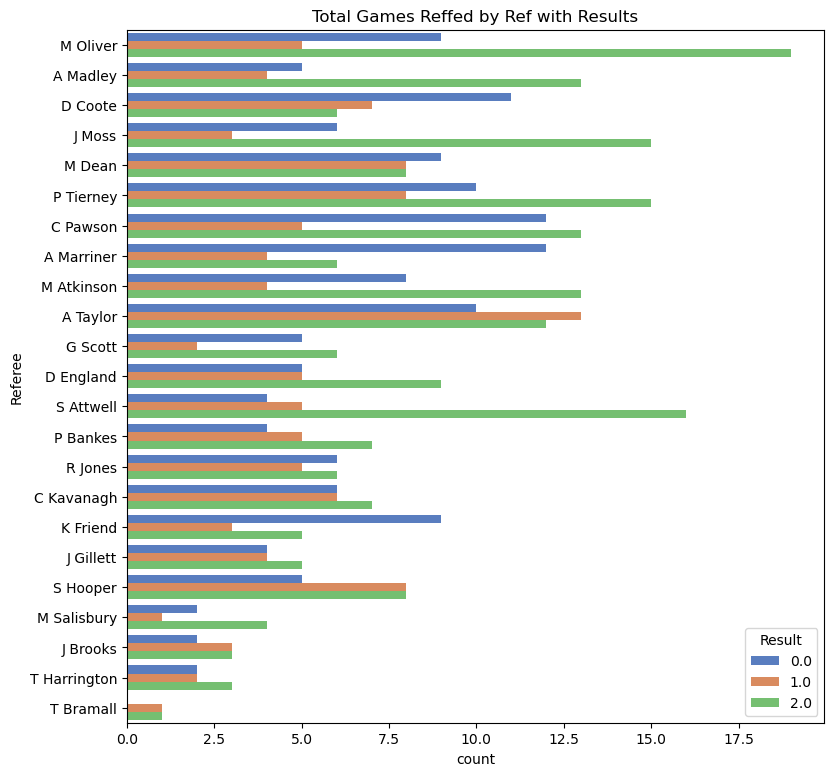

In [20]:
#Bar plot showing how many games each ref reffed
plt.figure(figsize=(9, 9))
sns.countplot(data = ref_impact, y="Referee", hue= 'Result', palette = 'muted')
plt.title("Total Games Reffed by Ref with Results")
plt.savefig(fname = '../figures/Total Games Reffed by Ref with Results', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

In [21]:
# percentage of value counts for target variable
final_dataset.Result.value_counts(normalize=True)

2.0    0.437637
0.0    0.319475
1.0    0.242888
Name: Result, dtype: float64

In [22]:
#stats for final_dataset
final_dataset.describe().round(2)

,B365H,B365D,B365A,HICT,AICT,DifICT,Result
count,457.00,457.00,457.00,457.00,457.00,457.00,457.00
mean,3.03,4.24,4.66,8262.01,8226.76,35.24,1.12
std,2.32,1.45,4.39,505.94,496.46,590.51,0.86
min,1.06,2.80,1.14,7300.00,7300.00,-1473.20,0.00
25%,1.61,3.40,2.15,7891.30,7864.20,-354.40,0.00
50%,2.25,3.75,3.25,8198.50,8145.80,30.40,1.00
75%,3.40,4.50,5.50,8568.40,8515.20,415.00,2.00
max,19.00,13.00,29.00,9801.00,9809.20,1573.30,2.00


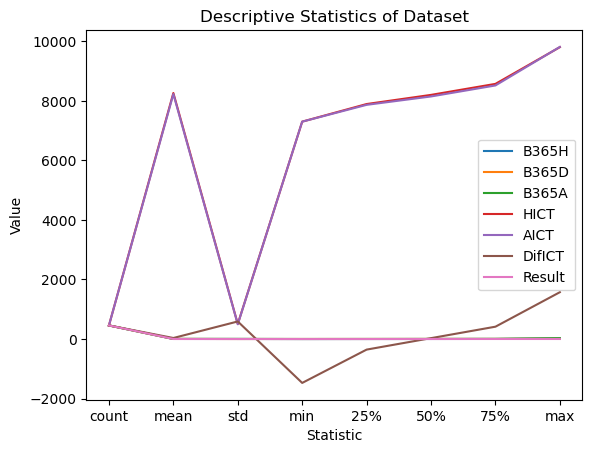

In [23]:
#stats for final_dataset plot
final_dataset.describe().round(2).plot()
plt.title("Descriptive Statistics of Dataset")
plt.ylabel("Value")
plt.xlabel("Statistic")
plt.savefig(fname = '../figures/Descriptive Statistics of Dataset', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

In [24]:
#info on final_dataset
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457 entries, 0 to 456
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Referee  457 non-null    object 
 1   B365H    457 non-null    float64
 2   B365D    457 non-null    float64
 3   B365A    457 non-null    float64
 4   HICT     457 non-null    float64
 5   AICT     457 non-null    float64
 6   DifICT   457 non-null    float64
 7   Result   457 non-null    float64
dtypes: float64(7), object(1)
memory usage: 28.7+ KB


In [25]:
#calculates correlation between Result and other values
correlation = final_dataset.corr().abs().unstack()
correlation = correlation.sort_values(ascending=False)
correlation.Result

Result    1.000000
DifICT    0.419218
B365H     0.412218
B365A     0.360987
AICT      0.256969
HICT      0.237133
B365D     0.169424
dtype: float64

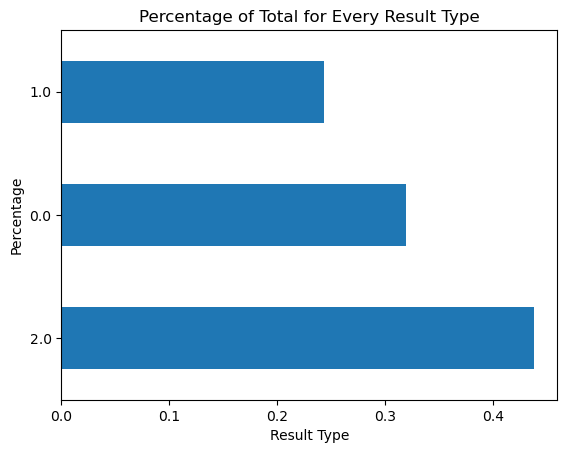

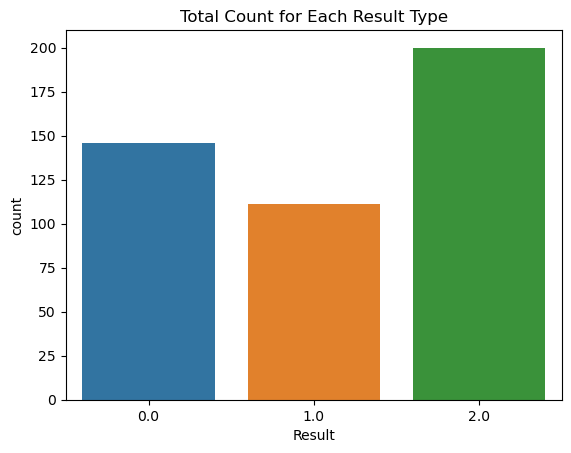

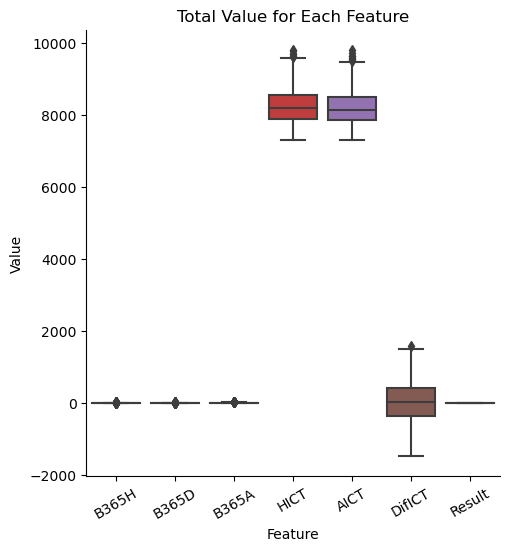

In [26]:
#count plots 
final_dataset.Result.value_counts(normalize=True).plot.barh()
plt.title("Percentage of Total for Every Result Type")
plt.savefig(fname = '../figures/Percentage of total for Each Result Type', format = 'png', dpi = 300, bbox_inches='tight')
plt.xlabel("Result Type")
plt.ylabel("Percentage")
plt.show()

count_plot = sns.countplot(x=final_dataset["Result"])
plt.title("Total Count for Each Result Type")
plt.savefig(fname = '../figures/Total Count for Each Result Type', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

fd_box = sns.catplot(data=final_dataset, kind="box")
fd_box.set_xticklabels(rotation=30)
plt.title("Total Value for Each Feature")
plt.ylabel("Value")
plt.xlabel("Feature")
plt.savefig(fname = '../figures/Total Value for Each Feature', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

In [27]:
#correlation between Result and specifc result outcomes
spearman = final_dataset[['Result', 'DifICT']].copy()
spearman['Home Wins']=(spearman['Result']==1.0).astype(int)
spearman['Away Wins']=(spearman['Result']==-1.0).astype(int)
spearman['Draw']=(spearman['Result']==0.0).astype(int)
my_r = spearman.corr(method="spearman")
print(my_r)

             Result    DifICT  Home Wins  Away Wins      Draw
Result     1.000000  0.406597  -0.124334        NaN -0.866223
DifICT     0.406597  1.000000  -0.003887        NaN -0.375703
Home Wins -0.124334 -0.003887   1.000000        NaN -0.388079
Away Wins       NaN       NaN        NaN        NaN       NaN
Draw      -0.866223 -0.375703  -0.388079        NaN  1.000000


In [28]:
spearman_noD = final_dataset[['Result', 'DifICT']].copy()
spearman_noD = spearman_noD[spearman_noD.Result != 0.0]
spearman_noD['Home Wins']=(spearman_noD['Result']==1.0).astype(int)
spearman_noD['Away wins']=(spearman_noD['Result']==-1.0).astype(int)
spearman_noD['Draw']=(spearman_noD['Result']==0.0).astype(int)
my_r = spearman_noD.corr(method="spearman")
print(my_r)

            Result   DifICT  Home Wins  Away wins  Draw
Result     1.00000  0.21377   -1.00000        NaN   NaN
DifICT     0.21377  1.00000   -0.21377        NaN   NaN
Home Wins -1.00000 -0.21377    1.00000        NaN   NaN
Away wins      NaN      NaN        NaN        NaN   NaN
Draw           NaN      NaN        NaN        NaN   NaN


In [29]:
spearman_win_draw = final_dataset[['Result', 'DifICT']].copy()
spearman_win_draw['Away Wins/Draws']=(spearman_win_draw['Result']!=1.0).astype(int)
spearman_win_draw['Home Wins/Draws']=(spearman_win_draw['Result']!=-1.0).astype(int)
my_r = spearman_win_draw.corr(method="spearman")
print(my_r)

                   Result    DifICT  Away Wins/Draws  Home Wins/Draws
Result           1.000000  0.406597         0.124334              NaN
DifICT           0.406597  1.000000         0.003887              NaN
Away Wins/Draws  0.124334  0.003887         1.000000              NaN
Home Wins/Draws       NaN       NaN              NaN              NaN


In [30]:
def display_correlation(df):
    r = df.corr(method="spearman")
    plt.figure(figsize=(10,6))
    heatmap = sns.heatmap(df.corr(), vmin=-1, 
                      vmax=1, annot=True)
    plt.title("Spearman Correlation - Result Types and DifICT")
    return(r)

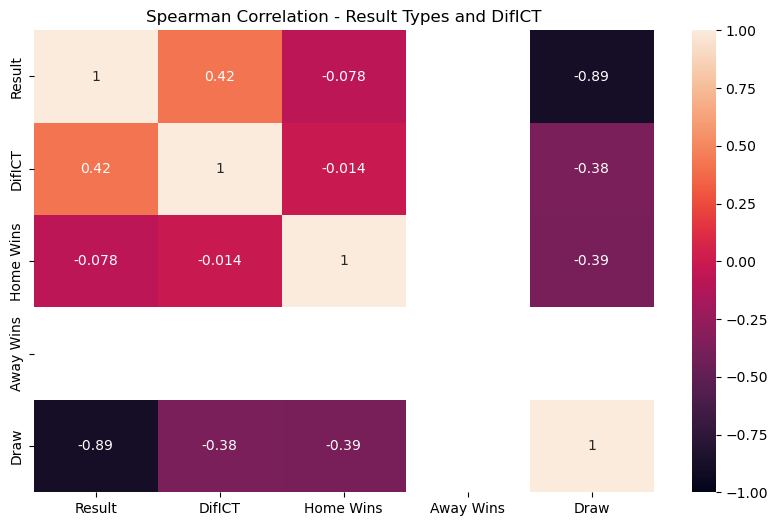

In [31]:
r_simple=display_correlation(spearman)
plt.savefig(fname = '../figures/Spearman Correlation', format = 'png', dpi = 300, bbox_inches='tight')

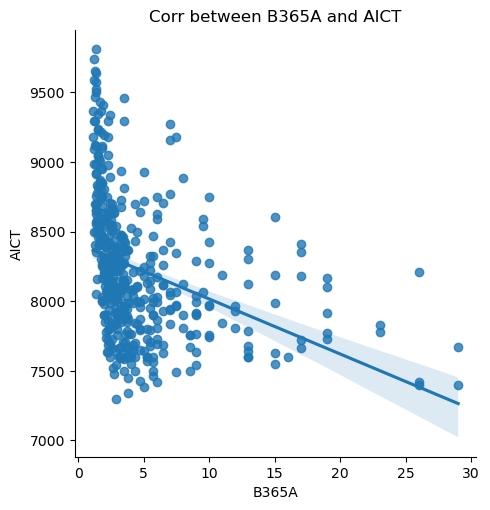

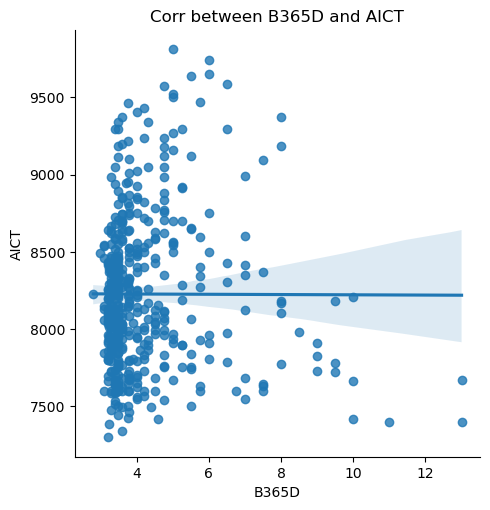

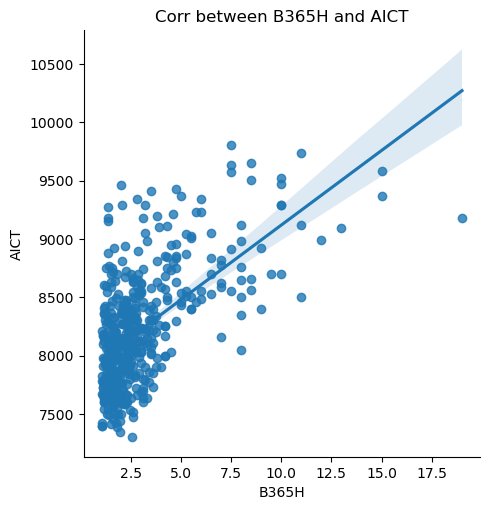

In [32]:
#scatter plots between odds and AICT
sns.lmplot(x='B365A',y='AICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365A and AICT")
plt.savefig(fname = '../figures/Corr between B365A and AICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.lmplot(x='B365D',y='AICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365D and AICT")
plt.savefig(fname = '../figures/Corr between B365D and AICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.lmplot(x='B365H',y='AICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365H and AICT")
plt.savefig(fname = '../figures/Corr between B365H and AICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

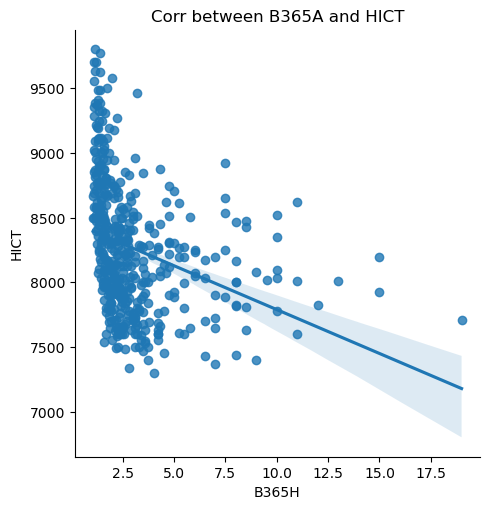

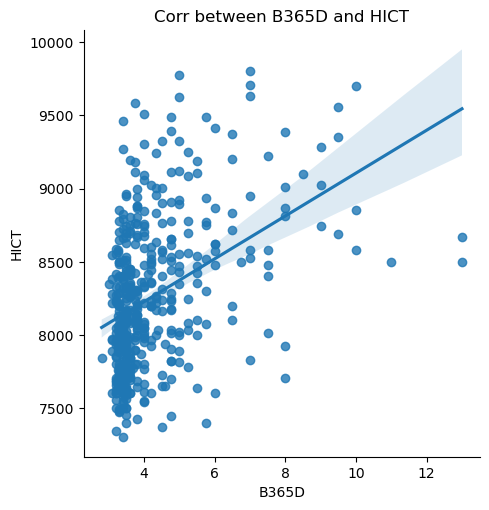

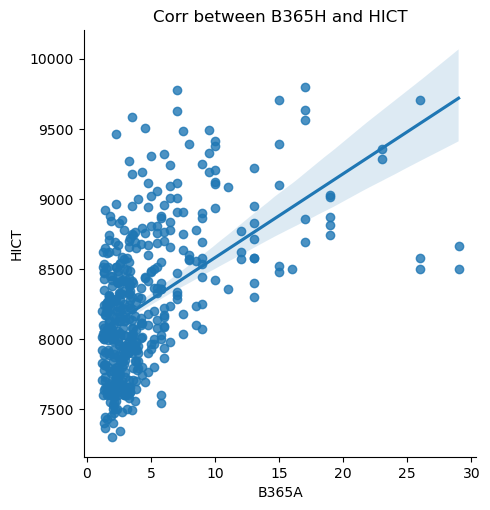

In [33]:
#scatter plots between odds and HICT
sns.lmplot(x='B365H',y='HICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365A and HICT")
plt.savefig(fname = '../figures/Corr between B365A and HICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.lmplot(x='B365D',y='HICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365D and HICT")
plt.savefig(fname = '../figures/Corr between B365D and HICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.lmplot(x='B365A',y='HICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365H and HICT")
plt.savefig(fname = '../figures/Corr between B365H and HICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

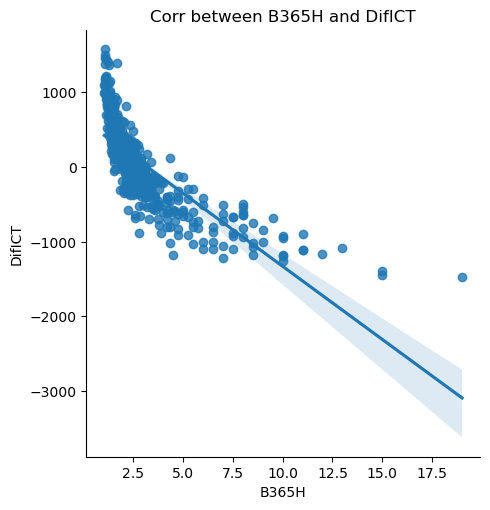

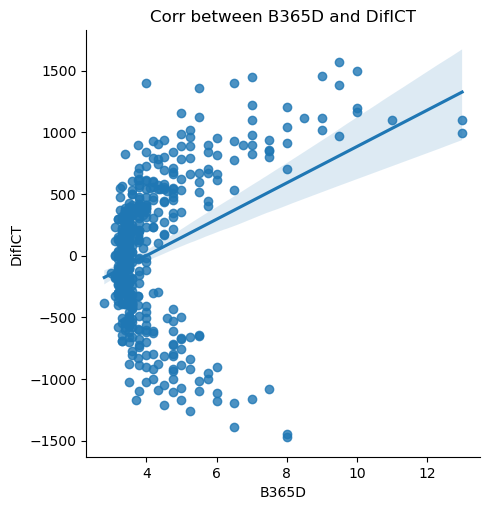

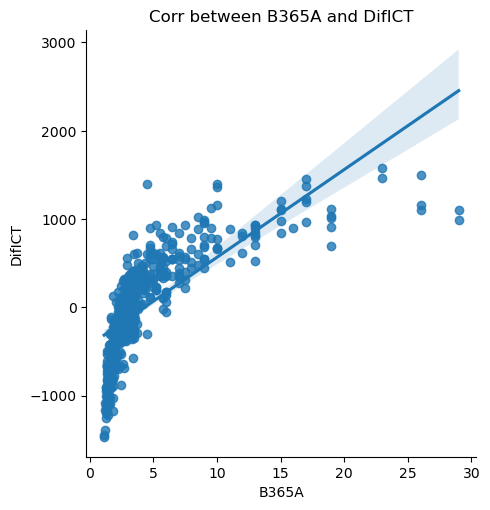

In [34]:
#scatter plots between odds and DifICT
sns.lmplot(x='B365H',y='DifICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365H and DifICT")
plt.savefig(fname = '../figures/Corr between B365H and DifICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.lmplot(x='B365D',y='DifICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365D and DifICT")
plt.savefig(fname = '../figures/Corr between B365D and DifICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.lmplot(x='B365A',y='DifICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365A and DifICT")
plt.savefig(fname = '../figures/Corr between B365A and DifICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

[ 0.99781182 -0.00707661  0.06121283 -0.06239719  0.04126072  0.00591132
  0.03895573  0.01011961 -0.04004851 -0.00469456]


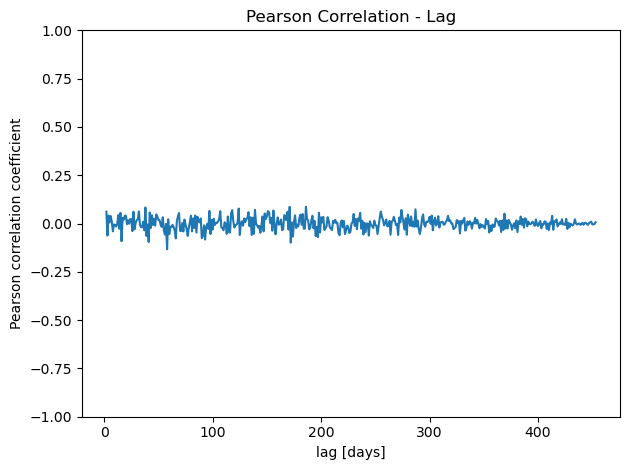

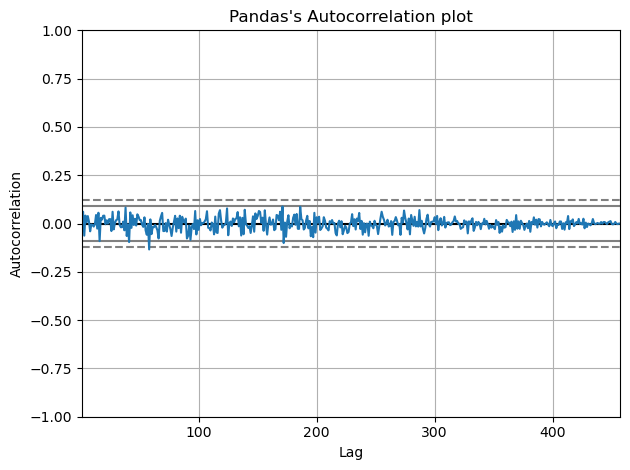

In [35]:
#auto correlation plot
lags = np.arange(457)
corr_coefs = np.zeros(457)

for i in np.arange(len(lags)):
    x = final_dataset['Result'].iloc[i:-1].reset_index(drop=True) # recent observations
    y = final_dataset['Result'].iloc[:-i-1].reset_index(drop=True) # lag-shifted observations
    # the shapes must be the same
    if x.shape != y.shape:
        raise ValueError('shape mismatch!')
    # Pearson correlation multiplied by the fraction of time series used
    corr_coefs[i] = x.corr(y,method='pearson')*x.shape[0]/final_dataset['Result'].shape[0]
print(corr_coefs[:10])

pearson_corr_lag = plt.plot(lags[2:],corr_coefs[2:])
plt.ylim([-1,1])
plt.xlabel('lag [days]')
plt.ylabel('Pearson correlation coefficient')
plt.title('Pearson Correlation - Lag')
plt.tight_layout()
plt.savefig(fname = '../figures/Pearson Correlation - Lag', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

# a one-liner
panda_auto_corr = pd.plotting.autocorrelation_plot(final_dataset['Result'])
plt.title("Pandas's Autocorrelation plot")
plt.tight_layout()
plt.savefig(fname = '../figures/Pandas Autocorrelation plot', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

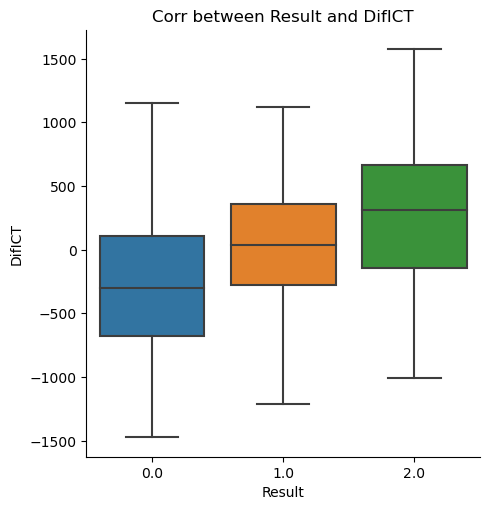

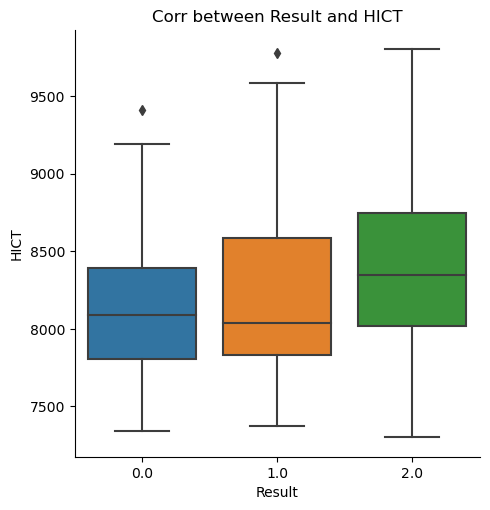

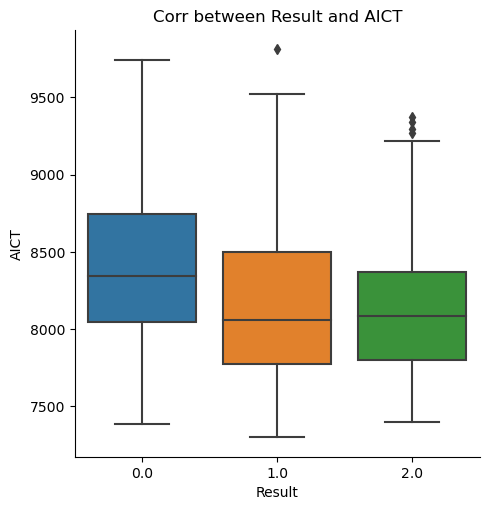

In [36]:
#box plot for result variable with DifICT, HICT, AICT
sns.catplot(data=final_dataset, x="Result", y="DifICT", kind="box")
plt.title("Corr between Result and DifICT")
plt.savefig(fname = '../figures/Corr between Result and DifICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.catplot(data=final_dataset, x="Result", y="HICT", kind="box")
plt.title("Corr between Result and HICT")
plt.savefig(fname = '../figures/Corr between Result and HICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.catplot(data=final_dataset, x="Result", y="AICT", kind="box")
plt.title("Corr between Result and AICT")
plt.savefig(fname = '../figures/Corr between Result and AICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

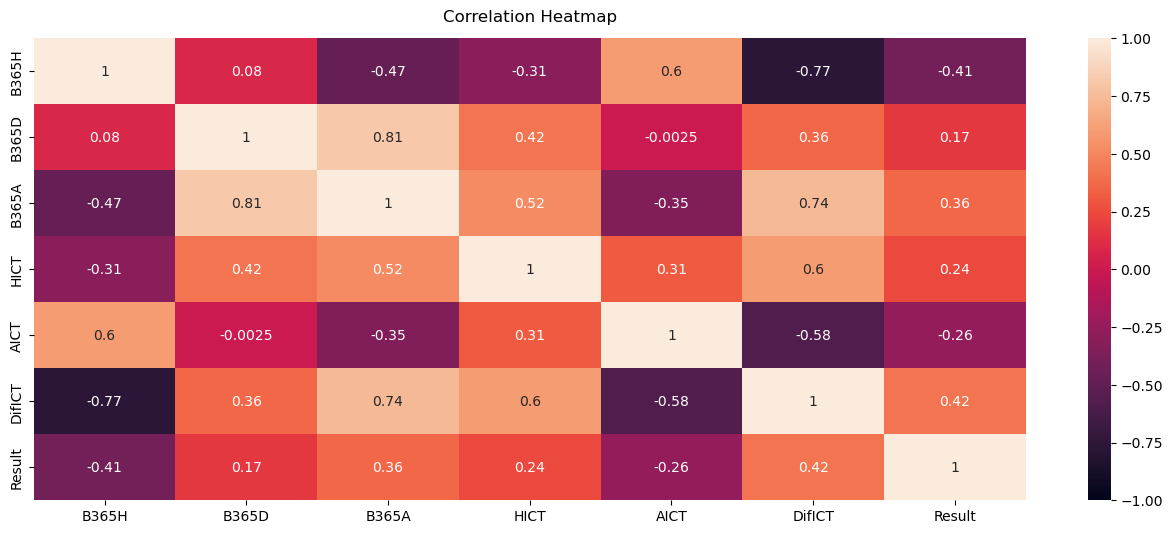

In [37]:
#Correlation Heatmap of all features
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(final_dataset.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.savefig(fname = '../figures/Correlation Heatmap - All Features', format = 'png', dpi = 300, bbox_inches='tight')

In [38]:
#pointbiserial
from scipy.stats import pointbiserialr

copy = final_dataset
copy = copy.drop('Result', axis=1)
copy = copy.drop('Referee', axis=1)
result = final_dataset.copy()

from scipy import stats
corr_list = []
y = result['Result'].astype(float)

for column in copy:
    x=copy[column]
    corr = stats.pointbiserialr(list(x), list(y))
    corr_list.append(corr[0])
print(corr_list)

[-0.41221816029361436, 0.16942449104528334, 0.3609873022870327, 0.23713297665884991, -0.25696913103474944, 0.41921754451477955]


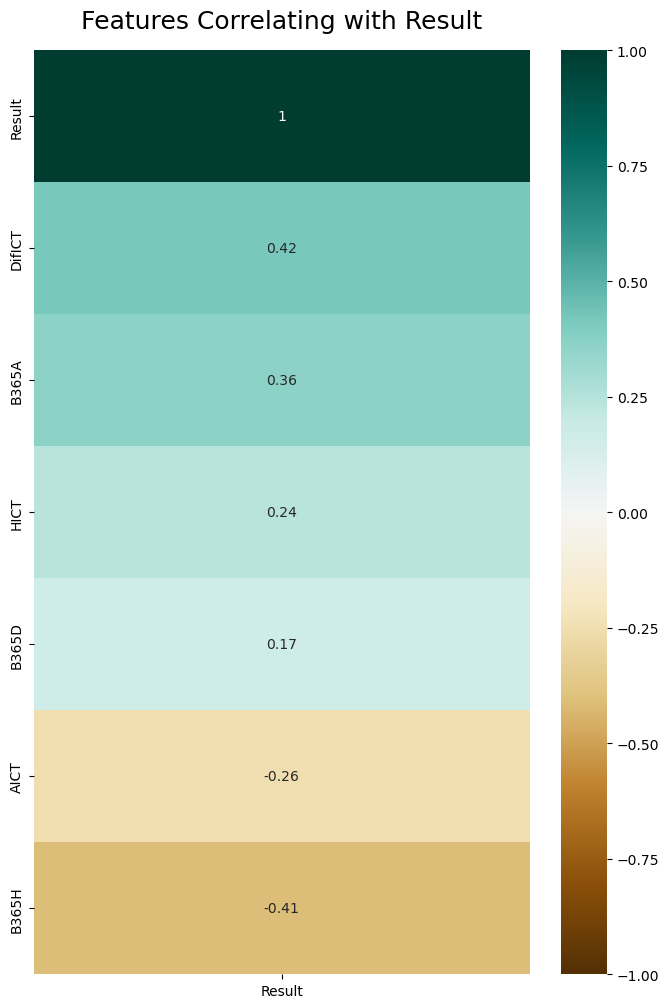

In [39]:
#Correlation Heatmap of all features with target variable
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(final_dataset.corr()[['Result']].sort_values(by='Result', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Result', fontdict={'fontsize':18}, pad=16);
plt.savefig(fname = '../figures/Features Correlating with Result', format = 'png', dpi = 300, bbox_inches='tight')

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 3)'>

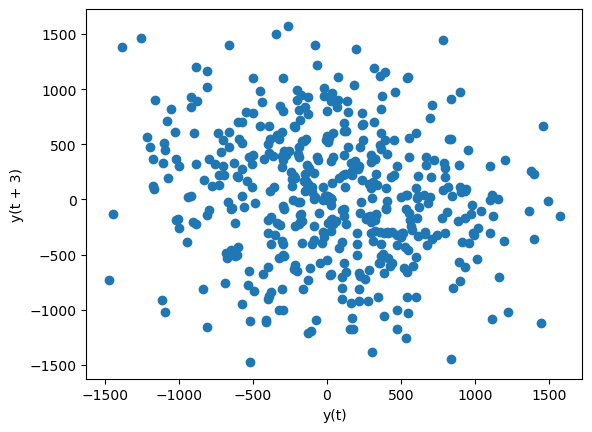

In [40]:
Referee = final_dataset['Referee']
Result = final_dataset['Result']
B365H = final_dataset['B365H']
B365D = final_dataset['B365D']
B365A = final_dataset['B365A']
HICT = final_dataset['HICT']
AICT = final_dataset['AICT']
ye = final_dataset[['DifICT', 'B365A', 'B365D', 'B365H']]

pd.plotting.lag_plot(ye, lag=3)

# Lagging

In [41]:
#features to lag (lag 7)
Referee = final_dataset['Referee']
Result = final_dataset['Result']
B365H = final_dataset['B365H']
B365D = final_dataset['B365D']
B365A = final_dataset['B365A']
HICT = final_dataset['HICT']
AICT = final_dataset['AICT']
DifICT = final_dataset['DifICT']

y7 = final_dataset['Result']
X7 = pd.concat([Referee, Result, 
                
B365H.shift(7),B365H.shift(6),B365H.shift(5),B365H.shift(4),B365H.shift(3),B365H.shift(2), B365H.shift(1),B365H, 
                
B365D.shift(7),B365D.shift(6), B365D.shift(5),B365D.shift(4),B365D.shift(3), B365D.shift(2),B365D.shift(1),B365D, 

B365A.shift(7),B365A.shift(6), B365A.shift(5),B365A.shift(4), B365A.shift(3),B365A.shift(2),B365A.shift(1),B365A, 

HICT.shift(7),HICT.shift(6), HICT.shift(5),HICT.shift(4),HICT.shift(3),HICT.shift(2),HICT.shift(1),HICT, 
               
AICT.shift(7),AICT.shift(6), AICT.shift(5),AICT.shift(4),AICT.shift(3),AICT.shift(2),AICT.shift(1),AICT, 
               
DifICT.shift(7),DifICT.shift(6), DifICT.shift(5),DifICT.shift(4),DifICT.shift(3),DifICT.shift(2),DifICT.shift(1),DifICT],
              
               axis=1)

X7.columns = ['Referee', 'Result',
              
              'B365H lag 7 matches','B365H lag 6 matches','B365H lag 5 matches', 'B365H lag 4 matches', 
              'B365H lag 3 matches','B365H lag 2 matches', 'B365H lag 1 match', 'B365H most recent match',
             
              'B365D lag 7 matches', 'B365D lag 6 matches', 'B365D lag 5 matches', 'B365D lag 4 matches', 
              'B365D lag 3 matches', 'B365D lag 2 matches', 'B365D lag 1 match', 'B365D most recent match',
             
              'B365A lag 7 matches', 'B365A lag 6 matches', 'B365A lag 5 matches', 'B365A lag 4 matches', 
              'B365A lag 3 matches','B365A lag 2 matches', 'B365A lag 1 match', 'B365A most recent match',       
             
              'HICT lag 7 matches', 'HICT lag 6 matches', 'HICT lag 5 matches', 'HICT lag 4 matches', 
              'HICT lag 3 matches','HICT lag 2 matches', 'HICT lag 1 match', 'HICT most recent match',       
             
              'AICT lag 7 matches', 'AICT lag 6 matches', 'AICT lag 5 matches', 'AICT lag 4 matches', 
              'AICT lag 3 matches','AICT lag 2 matches', 'AICT lag 1 match', 'AICT most recent match',
              
              'DifICT lag 7 matches', 'DifICT lag 6 matches', 'DifICT lag 5 matches', 'DifICT lag 4 matches', 
              'DifICT lag 3 matches','DifICT lag 2 matches', 'DifICT lag 1 match', 'DifICT most recent match'] 

# print(X7.tail(10))
# print(y7.tail(10))

In [42]:
#lag 5
y5 = final_dataset['Result']
X5 = pd.concat([Referee, Result, B365H.shift(5),B365H.shift(4),B365H.shift(3),B365H.shift(2),
               B365H.shift(1),B365H, B365D.shift(5),B365D.shift(4),B365D.shift(3),
               B365D.shift(2),B365D.shift(1),B365D, B365A.shift(5),B365A.shift(4),
               B365A.shift(3),B365A.shift(2),B365A.shift(1),B365A, HICT.shift(5),
               HICT.shift(4),HICT.shift(3),HICT.shift(2),HICT.shift(1),HICT, 
               AICT.shift(5),AICT.shift(4),AICT.shift(3),AICT.shift(2),AICT.shift(1),AICT, 
               DifICT.shift(5),DifICT.shift(4),DifICT.shift(3),DifICT.shift(2),DifICT.shift(1),DifICT],
              axis=1)

X5.columns = ['Referee', 'Result',
             
             'B365H lag 5 matches', 'B365H lag 4 matches', 'B365H lag 3 matches', 
             'B365H lag 2 matches', 'B365H lag 1 match', 'B365H most recent match',
             
             'B365D lag 5 matches', 'B365D lag 4 matches', 'B365D lag 3 matches', 
             'B365D lag 2 matches', 'B365D lag 1 match', 'B365D most recent match',
             
             'B365A lag 5 matches', 'B365A lag 4 matches', 'B365A lag 3 matches', 
             'B365A lag 2 matches', 'B365A lag 1 match', 'B365A most recent match',       
             
             'HICT lag 5 matches', 'HICT lag 4 matches', 'HICT lag 3 matches', 
             'HICT lag 2 matches', 'HICT lag 1 match', 'HICT most recent match',       
             
             'AICT lag 5 matches', 'AICT lag 4 matches', 'AICT lag 3 matches', 
             'AICT lag 2 matches', 'AICT lag 1 match', 'AICT most recent match',
             
             'DifICT lag 5 matches', 'DifICT lag 4 matches', 'DifICT lag 3 matches', 
             'DifICT lag 2 matches', 'DifICT lag 1 match', 'DifICT most recent match'] 

# print(X5.tail(10))
# print(y5.tail(10))

In [43]:
#lag 3
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score

Referee = final_dataset['Referee']
Result = final_dataset['Result']
B365H = final_dataset['B365H']
B365D = final_dataset['B365D']
B365A = final_dataset['B365A']
HICT = final_dataset['HICT']
AICT = final_dataset['AICT']
DifICT = final_dataset['DifICT']

y3 = final_dataset['Result']
X3 = pd.concat([Referee, Result, B365H.shift(3),B365H.shift(2),
               B365H.shift(1),B365H, B365D.shift(3), B365D.shift(2),B365D.shift(1),B365D, B365A.shift(3),
               B365A.shift(2),B365A.shift(1),B365A, HICT.shift(3),HICT.shift(2),HICT.shift(1),HICT, 
               AICT.shift(3),AICT.shift(2),AICT.shift(1),AICT, DifICT.shift(3),DifICT.shift(2),DifICT.shift(1),
               DifICT],axis=1)

X3.columns = ['Referee','Result','B365H lag 3 matches', 'B365H lag 2 matches', 'B365H lag 1 match', 
             'B365H most recent match','B365D lag 3 matches','B365D lag 2 matches', 'B365D lag 1 match', 
             'B365D most recent match','B365A lag 3 matches','B365A lag 2 matches', 'B365A lag 1 match', 
             'B365A most recent match', 'HICT lag 3 matches','HICT lag 2 matches', 'HICT lag 1 match', 
             'HICT most recent match','AICT lag 3 matches','AICT lag 2 matches', 'AICT lag 1 match', 
             'AICT most recent match', 'DifICT lag 3 matches','DifICT lag 2 matches', 'DifICT lag 1 match', 
             'DifICT most recent match'] 

# print(X3.tail(10))
# print(y3.tail(10))

In [44]:
#lag 1
y1 = final_dataset['Result']
X1 = pd.concat([Referee, Result, B365H.shift(1),B365H, B365D.shift(1),B365D,B365A.shift(1),B365A, HICT.shift(1),
               HICT ,AICT.shift(1),AICT,DifICT.shift(1), DifICT],axis=1)

X1.columns = ['Referee', 'Result','B365H lag 1 match', 
             'B365H most recent match', 'B365D lag 1 match', 
             'B365D most recent match', 'B365A lag 1 match', 
             'B365A most recent match', 'HICT lag 1 match', 
             'HICT most recent match','AICT lag 1 match', 
             'AICT most recent match', 'DifICT lag 1 match', 
             'DifICT most recent match'] 

# print(X1.tail(10))
# print(y1.tail(10))

# Encoding

In [45]:
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score



# collect which encoder to use on each feature
onehot_ftrs_7 = ['Referee']
minmax_ftrs_7 = ['HICT lag 7 matches', 'HICT lag 6 matches','HICT lag 5 matches', 'HICT lag 4 matches', 
                 'HICT lag 3 matches', 'HICT lag 2 matches', 'HICT lag 1 match', 'HICT most recent match',       
            
                 'AICT lag 7 matches', 'AICT lag 6 matches','AICT lag 5 matches', 'AICT lag 4 matches', 
                 'AICT lag 3 matches','AICT lag 2 matches', 'AICT lag 1 match', 'AICT most recent match']
               
std_ftrs_7 = ['B365H lag 7 matches', 'B365H lag 6 matches', 'B365H lag 5 matches', 'B365H lag 4 matches', 
              'B365H lag 3 matches','B365H lag 2 matches', 'B365H lag 1 match', 'B365H most recent match',
              
              'B365D lag 7 matches', 'B365D lag 6 matches', 'B365D lag 5 matches', 'B365D lag 4 matches', 
              'B365D lag 3 matches', 'B365D lag 2 matches', 'B365D lag 1 match', 'B365D most recent match',
              
              'B365A lag 7 matches', 'B365A lag 6 matches', 'B365A lag 5 matches', 'B365A lag 4 matches', 
              'B365A lag 3 matches', 'B365A lag 2 matches', 'B365A lag 1 match', 'B365A most recent match',       
              
              'DifICT lag 7 matches', 'DifICT lag 6 matches','DifICT lag 5 matches', 'DifICT lag 4 matches', 
              'DifICT lag 3 matches', 'DifICT lag 2 matches', 'DifICT lag 1 match', 'DifICT most recent match']
    
# collect all the encoders
preprocessor_7 = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs_7),
        ('minmax', MinMaxScaler(), minmax_ftrs_7),
        ('std', StandardScaler(), std_ftrs_7)])

#create dataframe for splitting
X7_lagged = X7.iloc[7:].reset_index(drop = True)
X7_lagged = X7_lagged.drop(['Result'], axis = 1)
y7_lagged = y7.iloc[7:].reset_index(drop = True)

In [46]:
# collect which encoder to use on each feature
onehot_ftrs_5 = ['Referee']
minmax_ftrs_5 = ['HICT lag 5 matches', 'HICT lag 4 matches', 'HICT lag 3 matches', 
               'HICT lag 2 matches', 'HICT lag 1 match', 'HICT most recent match',       
            
               'AICT lag 5 matches', 'AICT lag 4 matches', 'AICT lag 3 matches', 
               'AICT lag 2 matches', 'AICT lag 1 match', 'AICT most recent match']
               
std_ftrs_5 = ['B365H lag 5 matches', 'B365H lag 4 matches', 'B365H lag 3 matches', 
            'B365H lag 2 matches', 'B365H lag 1 match', 'B365H most recent match',
             
            'B365D lag 5 matches', 'B365D lag 4 matches', 'B365D lag 3 matches', 
            'B365D lag 2 matches', 'B365D lag 1 match', 'B365D most recent match',
             
            'B365A lag 5 matches', 'B365A lag 4 matches', 'B365A lag 3 matches', 
            'B365A lag 2 matches', 'B365A lag 1 match', 'B365A most recent match',       
             
            'DifICT lag 5 matches', 'DifICT lag 4 matches', 'DifICT lag 3 matches', 
            'DifICT lag 2 matches', 'DifICT lag 1 match', 'DifICT most recent match']
    
# collect all the encoders
preprocessor_5 = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs_5),
        ('minmax', MinMaxScaler(), minmax_ftrs_5),
        ('std', StandardScaler(), std_ftrs_5)])

#create dataframe for splitting
X5_lagged = X5.iloc[5:].reset_index(drop = True)
X5_lagged = X5_lagged.drop(['Result'], axis = 1)

y5_lagged = y5.iloc[5:].reset_index(drop = True)

In [47]:
# collect which encoder to use on each feature
onehot_ftrs_3 = ['Referee']
minmax_ftrs_3 = ['HICT lag 3 matches', 
               'HICT lag 2 matches', 'HICT lag 1 match', 'HICT most recent match',       
            
               'AICT lag 3 matches', 
               'AICT lag 2 matches', 'AICT lag 1 match', 'AICT most recent match']
               
std_ftrs_3 = ['B365H lag 3 matches', 
            'B365H lag 2 matches', 'B365H lag 1 match', 'B365H most recent match',
             
           'B365D lag 3 matches', 
            'B365D lag 2 matches', 'B365D lag 1 match', 'B365D most recent match',
             
            'B365A lag 3 matches', 
            'B365A lag 2 matches', 'B365A lag 1 match', 'B365A most recent match',       
             
            'DifICT lag 3 matches', 
            'DifICT lag 2 matches', 'DifICT lag 1 match', 'DifICT most recent match']
    
# collect all the encoders
preprocessor_3 = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs_3),
        ('minmax', MinMaxScaler(), minmax_ftrs_3),
        ('std', StandardScaler(), std_ftrs_3)])

#create dataframe for splitting
X3_lagged = X3.iloc[3:].reset_index(drop = True)
X3_lagged = X3_lagged.drop(['Result'], axis = 1)

y3_lagged = y3.iloc[3:].reset_index(drop = True)

In [48]:
# collect which encoder to use on each feature
onehot_ftrs_1 = ['Referee']
minmax_ftrs_1 = ['HICT lag 1 match', 'HICT most recent match',       
            
               'AICT lag 1 match', 'AICT most recent match']
               
std_ftrs_1 = ['B365H lag 1 match', 'B365H most recent match',
             
           'B365D lag 1 match', 'B365D most recent match',
             
             'B365A lag 1 match', 'B365A most recent match',       
             
            'DifICT lag 1 match', 'DifICT most recent match']
    
# collect all the encoders
preprocessor_1 = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs_1),
        ('minmax', MinMaxScaler(), minmax_ftrs_1),
        ('std', StandardScaler(), std_ftrs_1)])

#create dataframe for splitting
X1_lagged = X1.iloc[1:].reset_index(drop = True)
X1_lagged = X1_lagged.drop(['Result'], axis = 1)

y1_lagged = y1.iloc[1:].reset_index(drop = True)

# Models

In [49]:
#baseline
lag7_baseline= (194/(194 + 145 + 111)) * 100
lag5_baseline= (196/(196+145+111)) * 100
lag3_baseline= (198/(198+145+111)) * 100
lag1_baseline = (199/(199+146+111)) * 100
print(f'Baseline (7 Lags): {lag7_baseline:.3f}%')
print(f'Baseline (5 Lags): {lag5_baseline:.3f}%')
print(f'Baseline (3 Lags): {lag3_baseline:.3f}%')
print(f'Baseline (1 Lag): {lag1_baseline:.3f}%')

Baseline (7 Lags): 43.111%
Baseline (5 Lags): 43.363%
Baseline (3 Lags): 43.612%
Baseline (1 Lag): 43.640%


In [50]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import statistics as stat
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [51]:
def Modelcomparison(X, y, preprocessor, lags): 
    '''  '''
    models = []
    models.append(('L1_saga', LogisticRegression(max_iter= 100000,
                                                 penalty = 'l1', 
                                                 solver = 'saga')))
    models.append(('L2', LogisticRegression(penalty = 'l2')))
    models.append(('EN', LogisticRegression(max_iter= 100000, 
                                                 penalty = 'elasticnet', 
                                                 solver = 'saga', 
                                                 l1_ratio = 0.5)))
    models.append(('SVC', SVC()))
    models.append(('CATBOOST', CatBoostClassifier(logging_level = 'Silent')))

    # Evaluate each model in turn
    results = []
    names = []
    for name, model in models:
        # TimeSeries Cross validation
        tscv = TimeSeriesSplit(2)
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        prep = Pipeline(steps=[('preprocessor', preprocessor)])
        X_train_prep = prep.fit_transform(X_train)
        feature_names = prep.get_feature_names_out()
        df_train = pd.DataFrame(data=X_train_prep, columns=feature_names)
        cv_results = cross_val_score(model, df_train, y_train, cv=tscv, scoring='f1_micro')
        results.append(cv_results)
        names.append(name)
        mean = cv_results.mean() * 100
        std = cv_results.std() * 100
        
        #print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
        print(f'{name} ' f'score: {mean:.1f}%,', f'std: {std:.1f}%')

    # Compare Algorithms
    plt.boxplot(results, labels=names)
    plt.title('Algorithm Comparison at {} Lag(s)'.format(lags))
    plt.show()
    plt.savefig(fname = '../figures/Algorith Comparison at {} Lag(s)'.format(lags), format = 'png', dpi = 300, bbox_inches='tight')

Modelcomparison(X7_lagged, y7_lagged, preprocessor_7, 7)
Modelcomparison(X5_lagged, y5_lagged, preprocessor_5, 5)
Modelcomparison(X3_lagged, y3_lagged, preprocessor_3, 3)
Modelcomparison(X1_lagged, y1_lagged, preprocessor_1, 1)

NameError: name 'CatBoostClassifier' is not defined

In [ ]:
def Modelcomparison_log(X, y, preprocessor, lags): 
    '''  '''
    models = []
    models.append(('L1_liblinear', LogisticRegression(max_iter= 100000,
                                                 penalty = 'l1', 
                                                 solver = 'liblinear')))
    models.append(('L1_saga', LogisticRegression(max_iter= 100000,
                                                 penalty = 'l1', 
                                                 solver = 'saga')))
    models.append(('L2', LogisticRegression(penalty = 'l2')))
    models.append(('EN', LogisticRegression(max_iter= 100000, 
                                                 penalty = 'elasticnet', 
                                                 solver = 'saga', 
                                                 l1_ratio = 0.5)))

    # Evaluate each model in turn
    results = []
    names = []

    for name, model in models:
        # TimeSeries Cross validation
        tscv = TimeSeriesSplit(2)
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        prep = Pipeline(steps=[('preprocessor', preprocessor)])
        X_train_prep = prep.fit_transform(X_train)
        feature_names = prep.get_feature_names_out()
        df_train = pd.DataFrame(data=X_train_prep, columns=feature_names)
        cv_results = cross_val_score(model, df_train, y_train, cv=tscv, scoring='f1_micro')
        results.append(cv_results)
        names.append(name)
        mean = cv_results.mean() * 100
        std = cv_results.std() * 100
        
        print(f'{name} ' f'score: {mean:.1f}%,', f'std: {std:.1f}%')

    # Compare Algorithms
    plt.boxplot(results, labels=names)
    plt.title('Linear Algorithm Comparison at {} Lag(s)'.format(lags))
    plt.show()
    plt.savefig(fname = '../figures/Linear Alg Comparison at {} Lag(s)'.format(lags), format = 'png', dpi = 300, bbox_inches='tight')

Modelcomparison_log(X7_lagged, y7_lagged, preprocessor_7, 7)
Modelcomparison_log(X5_lagged, y5_lagged, preprocessor_5, 5)
Modelcomparison_log(X3_lagged, y3_lagged, preprocessor_3, 3)
Modelcomparison_log(X1_lagged, y1_lagged, preprocessor_1, 1)

In [ ]:
def MLpipe_RS_LR_Lasso(X, y, model, n_splits, preprocessor, scoring, refit, lags):
    ''''''
    tscv = TimeSeriesSplit(n_splits)

    best_models = []
    best_scores = []
    cm = []
    random_states = [1, 10, 42, 60, 90]
    
    for i in random_states:
        
        param_grid = {'ml__penalty': ['l1'], 
              'ml__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'ml__solver': ['liblinear', 'saga'],
              'ml__random_state': [i],
                     }
        
        split_scores = []
            
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            pipe = Pipeline(steps=[('preprocessor', preprocessor), ('ml', model)])
            gsearch = GridSearchCV(pipe, cv=tscv, param_grid= param_grid, scoring = scoring, refit = refit)
            gsearch.fit(X_train, y_train) 

            best_model = gsearch.best_estimator_
            best_score = gsearch.best_score_
            best_param = gsearch.best_params_
            feature_names = best_model[:-1].get_feature_names_out()

            y_pred = best_model.predict(X_test)
            test_score = accuracy_score(y_test,y_pred)
            best_scores.append(test_score)
            split_scores.append(test_score)
            cm.append(confusion_matrix(y_test,y_pred))
            best_models.append(best_model)
            print('---------------------------------------------------------------------------------------------------')
           
            print('\nBest Parameters\n')
            print(best_param)
            
            print('\nConfusion Matrix\n')
            print(confusion_matrix(y_test,y_pred))

            print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

            print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
            print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
            print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

            print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
            print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
            print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

            print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
            print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
            print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

            print('\nClassification Report\n')
            print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))
           
       
        score_split = stat.mean(split_scores) * 100
        score_split = score_split.round(3)
        std_split = stat.stdev(best_scores) * 100
        std_split = round(std_split,3)
        print('---------------------------------------------------------------------------------------------------')
        print('---------------------------------------------------------------------------------------------------')
        print(f'model: {model}, ' f'Averaged Split Accuracy score: {score_split:.2f}%, ' f'std: {std_split:.2f}%, ' f'# of Lags: {lags:.0f}')
        print('---------------------------------------------------------------------------------------------------')
    
    score = stat.mean(best_scores) * 100
    score = score.round(3)
    std = stat.stdev(best_scores) * 100
    std = round(std,3)
    
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    print(f'model: {model}, ' f'Averaged Accuracy score: {score:.2f}%, ' f'std: {std:.2f}%, ' f'# of Lags: {lags:.0f}')
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    
    return best_models, best_scores, cm, lags


In [ ]:
def MLpipe_RS_LR_Ridge(X, y, model, n_splits, preprocessor, scoring, refit, lags):
    ''''''
    tscv = TimeSeriesSplit(n_splits)

    best_models = []
    best_scores = []
    cm = []
    random_states = [1, 10, 42, 60, 90]
    
    for i in random_states:
        
        param_grid = {'ml__penalty': ['l2'], 
              'ml__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'ml__solver': ['liblinear', 'saga'],
              'ml__random_state': [i]
             }
        
        split_scores = []
            
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            pipe = Pipeline(steps=[('preprocessor', preprocessor), ('ml', model)])
            gsearch = GridSearchCV(pipe, cv=tscv, param_grid= param_grid, scoring = scoring, refit = refit)
            gsearch.fit(X_train, y_train) 

            best_model = gsearch.best_estimator_
            best_score = gsearch.best_score_
            best_param = gsearch.best_params_
            feature_names = best_model[:-1].get_feature_names_out()

            y_pred = best_model.predict(X_test)
            test_score = accuracy_score(y_test,y_pred)
            best_scores.append(test_score)
            split_scores.append(test_score)
            cm.append(confusion_matrix(y_test,y_pred))
            best_models.append(best_model)
            print('---------------------------------------------------------------------------------------------------')
           
            print('\nBest Parameters\n')
            print(best_param)
            
            print('\nConfusion Matrix\n')
            print(confusion_matrix(y_test,y_pred))

            print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

            print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
            print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
            print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

            print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
            print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
            print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

            print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
            print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
            print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

            print('\nClassification Report\n')
            print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))
           
       
        score_split = stat.mean(split_scores) * 100
        score_split = score_split.round(3)
        std_split = stat.stdev(best_scores) * 100
        std_split = round(std_split,3)
        print('---------------------------------------------------------------------------------------------------')
        print('---------------------------------------------------------------------------------------------------')
        print(f'model: {model}, ' f'Averaged Split Accuracy score: {score_split:.2f}%, ' f'std: {std_split:.2f}%, ' f'# of Lags: {lags:.0f}')
        print('---------------------------------------------------------------------------------------------------')
    
    score = stat.mean(best_scores) * 100
    score = score.round(3)
    std = stat.stdev(best_scores) * 100
    std = round(std,3)
    
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    print(f'model: {model}, ' f'Averaged Accuracy score: {score:.2f}%, ' f'std: {std:.2f}%, ' f'# of Lags: {lags:.0f}')
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    
    return best_models, best_scores, cm, lags


In [ ]:
def MLpipe_RS_LR_EN(X, y, model, n_splits, preprocessor, scoring, refit, lags):
    ''''''
    tscv = TimeSeriesSplit(n_splits)

    best_models = []
    best_scores = []
    cm = []
    random_states = [1, 10, 42, 60, 90]
    
    for i in random_states:
        param_grid = {'ml__penalty': ['elasticnet'], 
              'ml__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'ml__solver': ['saga'],
              'ml__random_state': [i],
              'ml__l1_ratio': [0.01, 0.99, 15]}
        
        split_scores = []
            
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            pipe = Pipeline(steps=[('preprocessor', preprocessor), ('ml', model)])
            gsearch = GridSearchCV(pipe, cv=tscv, param_grid= param_grid, scoring = scoring, refit = refit)
            gsearch.fit(X_train, y_train) 

            best_model = gsearch.best_estimator_
            best_score = gsearch.best_score_
            best_param = gsearch.best_params_
            feature_names = best_model[:-1].get_feature_names_out()

            y_pred = best_model.predict(X_test)
            test_score = accuracy_score(y_test,y_pred)
            best_scores.append(test_score)
            split_scores.append(test_score)
            cm.append(confusion_matrix(y_test,y_pred))
            best_models.append(best_model)
            
            print('---------------------------------------------------------------------------------------------------')
           
            print('\nBest Parameters\n')
            print(best_param)
            
            print('\nConfusion Matrix\n')
            print(confusion_matrix(y_test,y_pred))

            print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

            print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
            print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
            print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

            print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
            print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
            print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

            print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
            print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
            print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

            print('\nClassification Report\n')
            print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))
           
       
        score_split = stat.mean(split_scores) * 100
        score_split = score_split.round(3)
        std_split = stat.stdev(best_scores) * 100
        std_split = round(std_split,3)
        print('---------------------------------------------------------------------------------------------------')
        print('---------------------------------------------------------------------------------------------------')
        print(f'model: {model}, ' f'Averaged Split Accuracy score: {score_split:.2f}%, ' f'std: {std_split:.2f}%, ' f'# of Lags: {lags:.0f}')
        print('---------------------------------------------------------------------------------------------------')
    
    score = stat.mean(best_scores) * 100
    score = score.round(3)
    std = stat.stdev(best_scores) * 100
    std = round(std,3)
    
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    print(f'model: {model}, ' f'Averaged Accuracy score: {score:.2f}%, ' f'std: {std:.2f}%, ' f'# of Lags: {lags:.0f}')
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    
    return best_models, best_scores, cm, lags


In [ ]:
def MLpipe_RS_SVC(X, y, model, n_splits, preprocessor, scoring, refit, lags):
    ''''''
    tscv = TimeSeriesSplit(n_splits)

    best_models = []
    best_scores = []
    cm = []
    random_states = [1, 10, 42, 60, 90]
    
    for i in random_states:
        param_grid = {'ml__C': [1, 3, 10, 30, 100],
              'ml__kernel': ['linear'],
              'ml__gamma': ['auto', 'scale'],
              'ml__degree': range(1, 6, 1),
              'ml__random_state': [i],
              'ml__probability': [bool]}
        
        split_scores = []
            
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            pipe = Pipeline(steps=[('preprocessor', preprocessor), ('ml', model)])
            gsearch = GridSearchCV(pipe, cv=tscv, param_grid= param_grid, scoring = scoring, refit = refit)
            gsearch.fit(X_train, y_train) 

            best_model = gsearch.best_estimator_
            best_score = gsearch.best_score_
            best_param = gsearch.best_params_
            feature_names = best_model[:-1].get_feature_names_out()

            y_pred = best_model.predict(X_test)
            test_score = accuracy_score(y_test,y_pred)
            best_scores.append(test_score)
            split_scores.append(test_score)
            cm.append(confusion_matrix(y_test,y_pred))
            best_models.append(best_model)
            print('---------------------------------------------------------------------------------------------------')
           
            print('\nBest Parameters\n')
            print(best_param)
            
            print('\nConfusion Matrix\n')
            print(confusion_matrix(y_test,y_pred))

            print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

            print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
            print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
            print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

            print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
            print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
            print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

            print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
            print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
            print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

            print('\nClassification Report\n')
            print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))
           
       
        score_split = stat.mean(split_scores) * 100
        score_split = score_split.round(3)
        std_split = stat.stdev(best_scores) * 100
        std_split = round(std_split,3)
        print('---------------------------------------------------------------------------------------------------')
        print('---------------------------------------------------------------------------------------------------')
        print(f'model: {model}, ' f'Averaged Split Accuracy score: {score_split:.2f}%, ' f'std: {std_split:.2f}%, ' f'# of Lags: {lags:.0f}')
        print('---------------------------------------------------------------------------------------------------')
    
    score = stat.mean(best_scores) * 100
    score = score.round(3)
    std = stat.stdev(best_scores) * 100
    std = round(std,3)
    
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    print(f'model: {model}, ' f'Averaged Accuracy score: {score:.2f}%, ' f'std: {std:.2f}%, ' f'# of Lags: {lags:.0f}')
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    
    return best_models, best_scores, cm, lags


In [ ]:
def MLpipe_RS_CAT(X, y, model, n_splits, preprocessor, scoring, refit, lags):
    ''''''
    tscv = TimeSeriesSplit(n_splits)

    best_models = []
    best_scores = []
    cm = []
    random_seed = [1, 10, 42, 60, 90]
    
    for i in random_seed:
        
        param_grid = {'ml__depth':[3, 1, 10],
              'ml__random_seed': [i],
              'ml__iterations':[1, 10, 25],
              'ml__learning_rate':[.01, 0.03], 
              'ml__l2_leaf_reg':[5, 10, 100],
              'ml__border_count':[32, 5],
              'ml__thread_count':[4]}
        
        split_scores = []
            
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            pipe = Pipeline(steps=[('preprocessor', preprocessor), ('ml', model)])
            gsearch = GridSearchCV(pipe, cv=tscv, param_grid= param_grid, scoring = scoring, refit = refit)
            gsearch.fit(X_train, y_train) 

            best_model = gsearch.best_estimator_
            best_score = gsearch.best_score_
            best_param = gsearch.best_params_
            feature_names = best_model[:-1].get_feature_names_out()

            y_pred = best_model.predict(X_test)
            test_score = accuracy_score(y_test,y_pred)
            best_scores.append(test_score)
            split_scores.append(test_score)
            cm.append(confusion_matrix(y_test,y_pred))
            best_models.append(best_model)
            print('---------------------------------------------------------------------------------------------------')
           
            print('\nBest Parameters\n')
            print(best_param)
            
            print('\nConfusion Matrix\n')
            print(confusion_matrix(y_test,y_pred))

            print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

            print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
            print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
            print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

            print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
            print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
            print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

            print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
            print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
            print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

            print('\nClassification Report\n')
            print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))
           
       
        score_split = stat.mean(split_scores) * 100
        score_split = score_split.round(3)
        std_split = stat.stdev(best_scores) * 100
        std_split = round(std_split,3)
        print('---------------------------------------------------------------------------------------------------')
        print('---------------------------------------------------------------------------------------------------')
        print(f'model: {model}, ' f'Averaged Split Accuracy score: {score_split:.2f}%, ' f'std: {std_split:.2f}%, ' f'# of Lags: {lags:.0f}')
        print('---------------------------------------------------------------------------------------------------')
    
    score = stat.mean(best_scores) * 100
    score = score.round(3)
    std = stat.stdev(best_scores) * 100
    std = round(std,3)
    
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    print(f'model: {model}, ' f'Averaged Accuracy score: {score:.2f}%, ' f'std: {std:.2f}%, ' f'# of Lags: {lags:.0f}')
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    
    return best_models, best_scores, cm, lags


In [ ]:
lasso = LogisticRegression(max_iter=1)

lasso7, score_lasso7, cm_lasso7, lags_lasso7 = MLpipe_RS_LR_Lasso(X7_lagged, y7_lagged, lasso, 2,  preprocessor_7,'f1_micro','f1_micro',7)
lasso5, score_lasso5, cm_lasso5, lags_lasso5= MLpipe_RS_LR_Lasso(X5_lagged, y5_lagged, lasso, 2, preprocessor_5,'f1_micro','f1_micro',5)
lasso3, score_lasso3, cm_lasso3, lags_lasso3= MLpipe_RS_LR_Lasso(X3_lagged, y3_lagged, lasso, 2, preprocessor_3,'f1_macro','f1_micro',3)
lasso1, score_lasso1, cm_lasso1, lags_lasso1= MLpipe_RS_LR_Lasso(X1_lagged, y1_lagged, lasso, 2, preprocessor_1,'f1_macro','f1_micro',1)


In [ ]:
ridge = LogisticRegression(max_iter=1)

ridge7, score_ridge7, cm_ridge7, lags_ridge7 = MLpipe_RS_LR_Ridge(X7_lagged, y7_lagged, ridge, 2,  preprocessor_7,'f1_micro','f1_micro',7)
ridge5, score_ridge5, cm_ridge5, lags_ridge5 = MLpipe_RS_LR_Ridge(X5_lagged, y5_lagged, ridge, 2, preprocessor_5,'f1_micro','f1_micro',5)
ridge3, score_ridge3, cm_ridge3, lags_ridge3 = MLpipe_RS_LR_Ridge(X3_lagged, y3_lagged, ridge, 2, preprocessor_3,'f1_macro','f1_micro',3)
ridge1, score_ridge1, cm_ridge1, lags_rigde1 = MLpipe_RS_LR_Ridge(X1_lagged, y1_lagged, ridge, 2, preprocessor_1,'f1_macro','f1_micro',1)


In [ ]:
en = LogisticRegression(max_iter=1)

EN7_LR, score_en7, cm_en7, lags_en7 = MLpipe_RS_LR_EN(X7_lagged, y7_lagged, en, 2,  preprocessor_7,'f1_micro','f1_micro',7)
EN5_LR, score_en5, cm_en5, lags_en5 = MLpipe_RS_LR_EN(X5_lagged, y5_lagged, en, 2, preprocessor_5,'f1_micro','f1_micro',5)
EN3_LR, score_en3, cm_en3, lags_en3 = MLpipe_RS_LR_EN(X3_lagged, y3_lagged, en, 2, preprocessor_3,'f1_macro','f1_micro',3)
EN1_LR, score_en1, cm_en1, lags_en1 = MLpipe_RS_LR_EN(X1_lagged, y1_lagged, en, 2, preprocessor_1,'f1_macro','f1_micro',1)


In [ ]:
svc = SVC()

svc7, score_svc7, cm_svc5, lags_svc7 = MLpipe_RS_SVC(X7_lagged, y7_lagged, svc, 2, preprocessor_7, 'accuracy', 'f1_micro',7)
svc5, score_svc5, cm_svc5, lags_svc5 = MLpipe_RS_SVC(X5_lagged, y5_lagged, svc, 2, preprocessor_5, 'accuracy', 'f1_micro',5)
svc3, score_svc3, cm_svc3, lags_svc3 = MLpipe_RS_SVC(X3_lagged, y3_lagged, svc, 2, preprocessor_3, 'accuracy', 'f1_micro',3)
svc1, score_svc1, cm_svc1, lags_svc1 = MLpipe_RS_SVC(X1_lagged, y1_lagged, svc, 2, preprocessor_1, 'accuracy', 'f1_micro',1)


In [ ]:
from catboost import CatBoostClassifier
CATB = CatBoostClassifier(logging_level = 'Silent')

cat7, score_cat7, cm_cat7, lags_cat7 = MLpipe_RS_CAT(X7_lagged, y7_lagged, CATB, 2,  preprocessor_7,'f1_micro','f1_micro',7)
cat5, score_cat5, cm_cat5, lags_cat5 = MLpipe_RS_CAT(X5_lagged, y5_lagged, CATB, 2, preprocessor_5,'f1_micro','f1_micro',5)
cat3, score_cat3, cm_cat3, lags_cat3 = MLpipe_RS_CAT(X3_lagged, y3_lagged, CATB, 2, preprocessor_3,'f1_micro','f1_micro',3)
cat, score_cat, cm_cat, lags_cat = MLpipe_RS_CAT(X1_lagged, y1_lagged, CATB, 2, preprocessor_1,'f1_micro','f1_micro',1)


## Results

In [ ]:
en_scores = [['EN 1 lag', score_en1], ['EN 3 lag', score_en3],['EN 5 lag', score_en5],['EN 7 lag', score_en7]]
ridge_scores = [['L2 1 lag', score_ridge1], ['L2 3 lag', score_ridge3],['L2 5 lag', score_ridge5],['L2 7 lag', score_ridge7]]
lasso_scores = [['L1 1 lag', score_lasso1], ['L1 3 lag', score_lasso3],['L1 5 lag', score_lasso5],['L1 7 lag', score_lasso7]]
cat_scores = [['CAT 1 lag', score_cat], ['CAT 3 lag', score_cat3],['CAT 5 lag', score_cat5],['CAT 7 lag', score_cat7]]
svc_scores = [['SVC 1 lag', score_svc1], ['SVC 3 lag', score_svc3],['SVC 5 lag', score_svc5],['SVC 7 lag', score_svc7]]


In [ ]:
def transform_scores(lists):
    first_split = []
    second_split =[]
    for score in lists:
        first_split.append(score[1][0::2])
        second_split.append(score[1][1::2])
    return first_split, second_split

def set_column_sequence(dataframe, seq, front=True):
    '''Takes a dataframe and a subsequence of its columns,
       returns dataframe with seq as first columns if "front" is True,
       and seq as last columns if "front" is False.
    '''
    cols = seq[:]
    for x in dataframe.columns:
        if x not in cols:
            if front:
                cols.append(x)
            else:
                cols.insert(0, x)
    return dataframe[cols]

def make_table(scores, model_name):
    c1, c2 = transform_scores(scores)
    split1 = pd.DataFrame(c1, columns = ['R1','R2','R3','R4','R5']).T
    split1.columns = ['Lag 1', 'Lag 3', 'Lag 5', 'Lag 7']
    split1 = split1.melt()
    split1['Model Type'] = model_name
    split1['RS'] = split1.groupby('variable').cumcount()+1
    split1_table = set_column_sequence(split1, ['Model Type', 'variable'])
    split1_table['Split'] = 1
    split1_table.columns = ['Model Type', 'Lag', 'Score', 'RS', 'Split']
    

    split2 = pd.DataFrame(c2, columns = ['R1','R2','R3','R4','R5']).T
    split2.columns = ['Lag 1', 'Lag 3', 'Lag 5', 'Lag 7']
    split2 = split2.melt()
    split2['Model Type'] = model_name
    split2['RS'] = split2.groupby('variable').cumcount()+1
    split2_table = set_column_sequence(split2, ['Model Type', 'variable'])
    split2_table['Split'] = 2
    split2_table.columns = ['Model Type', 'Lag', 'Score', 'RS', 'Split']
    
    combined = pd.concat([split1_table, split2_table]).reset_index(drop=True)
    combined.columns = ['Model Type', 'Lag', 'Score', 'RS', 'Split']
    return split1_table, split2_table, combined

EN_1, EN_2, EN_c = make_table(en_scores,'Elastic Net')
L2_1, L2_2, L2_c = make_table(ridge_scores,'L2')
L1_1, L1_2, L1_c = make_table(lasso_scores,'L1')
svc_1, svc_2, svc_c = make_table(svc_scores,'SVC')
cat_1, cat_2, cat_c = make_table(cat_scores,'CATBOOST')

def merged(c1, c2, c3, c4, c5):
    
    df_merged = c1.append(c2)
    df_merged = df_merged.append(c3)
    df_merged = df_merged.append(c4)
    df_merged = df_merged.append(c5)
    df_merged.reset_index(drop = True)
    return df_merged

df_merged_1 = merged(EN_1, L1_1, L2_1, svc_1, cat_1)
df_merged_2 = merged(EN_2, L1_2, L2_2, svc_1, cat_2)
df_merged_c =merged(EN_c, L1_c, L2_c, svc_c, cat_c)
top_models = df_merged_c.sort_values('Score', ascending = False).reset_index(drop=True)

In [ ]:
def calc_score(df, string):
    selected_df =df.loc[(df['Model Type'] == string)]
    mean = selected_df['Score'].mean()
    std = selected_df['Score'].std()
    sem = selected_df['Score'].sem()
    return [mean, std, sem]

def calc_score_RS(df, string, num):
    selected_df =df.loc[(df['Model Type'] == string) & (df['RS'] == num)]
    mean = selected_df['Score'].mean()
    std = selected_df['Score'].std()
    sem = selected_df['Score'].sem()
    return [mean, std, sem]

def merge_v2(df):
    s5 = calc_score(df, 'Elastic Net')
    s4 = calc_score(df, 'L1')
    s3= calc_score(df, 'L2')
    s2= calc_score(df, 'CATBOOST')
    s1 = calc_score(df, 'SVC')
    s1df = pd.DataFrame(s1).T
    s2df = pd.DataFrame(s2).T
    s3df = pd.DataFrame(s3).T
    s4df = pd.DataFrame(s4).T
    s5df = pd.DataFrame(s5).T
    s1df.columns = ['Mean', 'STD', 'SEM']
    s2df.columns = ['Mean', 'STD', 'SEM']
    s3df.columns = ['Mean', 'STD', 'SEM']
    s4df.columns = ['Mean', 'STD', 'SEM']
    s5df.columns = ['Mean', 'STD', 'SEM']
    new_df = s1df.append(s2df)
    new_df = new_df.append(s3df)
    new_df = new_df.append(s4df)
    new_df = new_df.append(s5df)
    new_df = new_df.T
    new_df.columns = ['SVC', 'CATBOOST', 'L2', 'L1', 'Elastic Net']
    new_df = new_df.T
    return new_df

def merge_v2_RS(df, num):
    s5 = calc_score_RS(df, 'Elastic Net', num)
    s4 = calc_score_RS(df, 'L1',num)
    s3= calc_score_RS(df, 'L2',num)
    s2= calc_score_RS(df, 'CATBOOST',num)
    s1 = calc_score_RS(df, 'SVC',num)
    s1df = pd.DataFrame(s1).T
    s2df = pd.DataFrame(s2).T
    s3df = pd.DataFrame(s3).T
    s4df = pd.DataFrame(s4).T
    s5df = pd.DataFrame(s5).T
    s1df.columns = ['Mean', 'STD', 'SEM']
    s2df.columns = ['Mean', 'STD', 'SEM']
    s3df.columns = ['Mean', 'STD', 'SEM']
    s4df.columns = ['Mean', 'STD', 'SEM']
    s5df.columns = ['Mean', 'STD', 'SEM']
    new_df = s1df.append(s2df)
    new_df = new_df.append(s3df)
    new_df = new_df.append(s4df)
    new_df = new_df.append(s5df)
    new_df = new_df.T
    new_df.columns = ['SVC', 'CATBOOST', 'L2', 'L1', 'Elastic Net']
    new_df= new_df.T
    return new_df

#overall
model_stat_split1 = merge_v2(df_merged_1)
model_stat_split2 = merge_v2(df_merged_2)
model_stat_splitc = merge_v2(df_merged_c)

#RS1
model_stat_split1rs1 = merge_v2_RS(df_merged_1, 1)
model_stat_split2rs1 = merge_v2_RS(df_merged_2, 1)
model_stat_splitcrs1 = merge_v2_RS(df_merged_c, 1)

#RS2
model_stat_split1rs2 = merge_v2_RS(df_merged_1, 2)
model_stat_split2rs2 = merge_v2_RS(df_merged_2, 2)
model_stat_splitcrs2 = merge_v2_RS(df_merged_c, 2)

#RS3
model_stat_split1rs3 = merge_v2_RS(df_merged_1, 3)
model_stat_split2rs3 = merge_v2_RS(df_merged_2, 3)
model_stat_splitcrs3 = merge_v2_RS(df_merged_c, 3)

#RS4
model_stat_split1rs4 = merge_v2_RS(df_merged_1, 4)
model_stat_split2rs4 = merge_v2_RS(df_merged_2, 4)
model_stat_splitcrs4 = merge_v2_RS(df_merged_c, 4)

#RS15
model_stat_split1rs5 = merge_v2_RS(df_merged_1, 5)
model_stat_split2rs5 = merge_v2_RS(df_merged_2, 5)
model_stat_splitcrs5 = merge_v2_RS(df_merged_c, 5)

def selected_score(df, string):
    selected_df =df.loc[(df['Model Type'] == string)]
    return selected_df

def create_mean_at_lag(df, s1, s2, s3, s4, s5, lag):
    s1m =  selected_score(df, s1)
    lag_model1 = s1m.loc[(s1m['Lag'] == lag)]
    
    s2m =  selected_score(df, s2)
    lag_model2 = s2m.loc[(s2m['Lag'] == lag)]
    
    s3m =  selected_score(df, s3)
    lag_model3 = s3m.loc[(s3m['Lag'] == lag)]
    
    s4m =  selected_score(df, s4)
    lag_model4 = s4m.loc[(s4m['Lag'] == lag)]
    
    s5m =  selected_score(df, s5)
    lag_model5 = s5m.loc[(s5m['Lag'] == lag)]
    
    mean1 = lag_model1['Score'].mean()
    mean2 = lag_model2['Score'].mean()
    mean3 = lag_model3['Score'].mean()
    mean4 = lag_model4['Score'].mean()
    mean5= lag_model5['Score'].mean()
    mean_df= pd.DataFrame([mean1, mean2,mean3,mean4,mean5]) 
    mean_df = mean_df.T
    mean_df.columns = [s1,s2,s3,s4,s5]
    mean_df = mean_df.T
    mean_df.columns = ['Score']

    return mean_df

def create_mean_at_rs(df, s1, s2, s3, s4, s5, rs):
    s1m =  selected_score(df, s1)
    rs_model1 = s1m.loc[(s1m['RS'] == rs)]
    
    s2m =  selected_score(df, s2)
    rs_model2 = s2m.loc[(s2m['RS'] == rs)]
    
    s3m =  selected_score(df, s3)
    rs_model3 = s3m.loc[(s3m['RS'] == rs)]
    
    s4m =  selected_score(df, s4)
    rs_model4 = s4m.loc[(s4m['RS'] == rs)]
    
    s5m =  selected_score(df, s5)
    rs_model5 = s5m.loc[(s5m['RS'] == rs)]
    
    mean1 = rs_model1['Score'].mean()
    mean2 = rs_model2['Score'].mean()
    mean3 = rs_model3['Score'].mean()
    mean4 = rs_model4['Score'].mean()
    mean5= rs_model5['Score'].mean()
    mean_df= pd.DataFrame([mean1, mean2,mean3,mean4,mean5]) 
    mean_df = mean_df.T
    mean_df.columns = [s1,s2,s3,s4,s5]
    mean_df = mean_df.T
    mean_df.columns = ['Score']

    return mean_df

lag1_scores1 = create_mean_at_lag(df_merged_1, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lag 1')
lag3_scores1 = create_mean_at_lag(df_merged_1, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lag 3')
lag5_scores1 = create_mean_at_lag(df_merged_1, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lag 5')
lag7_scores1 = create_mean_at_lag(df_merged_1, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lag 7')

lag1_scores2 = create_mean_at_lag(df_merged_2, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lag 1')
lag3_scores2 = create_mean_at_lag(df_merged_2, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lag 3')
lag5_scores2 = create_mean_at_lag(df_merged_2, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lag 5')
lag7_scores2 = create_mean_at_lag(df_merged_2, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lag 7')

lag1_scoresc = create_mean_at_lag(df_merged_c, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lag 1')
lag3_scoresc = create_mean_at_lag(df_merged_c, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lag 3')
lag5_scoresc = create_mean_at_lag(df_merged_c, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lag 5')
lag7_scoresc = create_mean_at_lag(df_merged_c, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lag 7')


rs1_scores1 = create_mean_at_rs(df_merged_1, 'Elastic Net','SVC','L1','L2','CATBOOST', 1)
rs2_scores1 = create_mean_at_rs(df_merged_1, 'Elastic Net','SVC','L1','L2','CATBOOST', 2)
rs3_scores1 = create_mean_at_rs(df_merged_1, 'Elastic Net','SVC','L1','L2','CATBOOST', 3)
rs4_scores1 = create_mean_at_rs(df_merged_1, 'Elastic Net','SVC','L1','L2','CATBOOST', 4)
rs5_scores1 = create_mean_at_rs(df_merged_1, 'Elastic Net','SVC','L1','L2','CATBOOST', 5)

rs1_scores2 = create_mean_at_rs(df_merged_2, 'Elastic Net','SVC','L1','L2','CATBOOST', 1)
rs2_scores2 = create_mean_at_rs(df_merged_2, 'Elastic Net','SVC','L1','L2','CATBOOST', 2)
rs3_scores2 = create_mean_at_rs(df_merged_2, 'Elastic Net','SVC','L1','L2','CATBOOST', 3)
rs4_scores2 = create_mean_at_rs(df_merged_2, 'Elastic Net','SVC','L1','L2','CATBOOST', 4)
rs5_scores2 = create_mean_at_rs(df_merged_2, 'Elastic Net','SVC','L1','L2','CATBOOST', 5)

rs1_scoresc = create_mean_at_rs(df_merged_c, 'Elastic Net','SVC','L1','L2','CATBOOST', 1)
rs2_scoresc = create_mean_at_rs(df_merged_c, 'Elastic Net','SVC','L1','L2','CATBOOST', 2)
rs3_scoresc = create_mean_at_rs(df_merged_c, 'Elastic Net','SVC','L1','L2','CATBOOST', 3)
rs4_scoresc = create_mean_at_rs(df_merged_c, 'Elastic Net','SVC','L1','L2','CATBOOST', 4)
rs5_scoresc = create_mean_at_rs(df_merged_c, 'Elastic Net','SVC','L1','L2','CATBOOST', 5)


In [ ]:
def all_lags(s1, s3, s5, s7):
    s1_copy = s1.copy()
    s1_copy['3 lags']= s3['Score']
    s1_copy['5 lags']= s5['Score']
    s1_copy['7 lags']= s7['Score']
    s1_copy.columns = ['1 Lag', '3 lags', '5 lags', '7 lags']
    return s1_copy


def all_rs(s1, s2, s3, s4,s5):
    s1_copy = s1.copy()
    s1_copy['10']= s2['Score']
    s1_copy['42']= s3['Score']
    s1_copy['60']= s3['Score']
    s1_copy['90']= s3['Score']
    s1_copy.columns = ['1', '10', '42', '60', '90']
    return s1_copy


all_lagsc = all_lags(lag1_scoresc, lag3_scoresc, lag5_scoresc, lag7_scoresc)
all_lags1 = all_lags(lag1_scores1, lag3_scores1, lag5_scores1, lag7_scores1)
all_lags2 = all_lags(lag1_scores2, lag3_scores2, lag5_scores2, lag7_scores2)


all_rs1 = all_rs(rs1_scores1, rs2_scores1, rs3_scores1, rs4_scores1, rs5_scores1)
all_rs2 = all_rs(rs1_scores2, rs2_scores2, rs3_scores2, rs4_scores2, rs5_scores2)
all_rsc = all_rs(rs1_scoresc, rs2_scoresc, rs3_scoresc, rs4_scoresc, rs5_scoresc)

#lag1_scoresc = lag1_scoresc.drop(['3 lags', '5 lags', '7 lags'], axis = 1)
#lag1_scores1 = lag1_scores1.drop(['3 lags', '5 lags', '7 lags'], axis = 1)
#lag1_scores2 = lag1_scores2.drop(['3 lags', '5 lags', '7 lags'], axis = 1)

In [ ]:
lag1_scoresc.columns = ['Score']
lag1_scores1.columns = ['Score']
lag1_scores2.columns = ['Score']

In [ ]:
all_lags1.T.plot(figsize=(12,8), grid=True)
plt.xlabel('# of Lags')
plt.ylabel('Accuracy Score (%)')
plt.title('Different Model Performance based on # of Lags Used (First Split)')
plt.savefig(fname = '../figures/Different Model Performance based on # of Lags Used (First Split)', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

all_lags2.T.plot(figsize=(12,8), grid=True)
plt.xlabel('# of Lags')
plt.ylabel('Accuracy Score (%)')
plt.title('Different Model Performance based on # of Lags Used (Second Split)')
plt.savefig(fname = '../figures/Different Model Performance based on # of Lags Used (Second Split)', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

all_lagsc.T.plot(figsize=(12,8), grid=True)
plt.xlabel('# of Lags')
plt.ylabel('Accuracy Score (%)')
plt.title('Different Model Performance based on # of Lags Used (Combined Split)')
plt.savefig(fname = '../figures/Different Model Performance based on # of Lags Used (Combined Split)', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()


In [ ]:
all_rs1.T.plot(figsize=(12,8), grid=True)
plt.xlabel('Random State')
plt.ylabel('Accuracy Score (%)')
plt.title('Different Model Performance based on Random State (First Split)')
plt.savefig(fname = '../figures/Different Model Performance based on Random State (First Split)', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

all_rs2.T.plot(figsize=(12,8), grid=True)
plt.xlabel('Random State')
plt.ylabel('Accuracy Score (%)')
plt.title('Different Model Performance based on Random State (Second Split)')
plt.savefig(fname = '../figures/Different Model Performance based on Random State (Second Split)', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

all_rsc.T.plot(figsize=(12,8), grid=True)
plt.xlabel('Random State')
plt.ylabel('Accuracy Score (%)')
plt.title('Different Model Performance based on Random State (Combined Split)')
plt.savefig(fname = '../figures/Different Model Performance based on Random State (Combined Split)', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()


In [ ]:
model_stat_split1['Mean'].plot(figsize=(8,5), grid=True)
plt.xlabel('Model')
plt.ylabel('Accuracy Score (%)')
plt.title('Overall Model Performance (First Split)')
plt.errorbar(model_stat_split1.index, model_stat_split1['Mean'], yerr=model_stat_split1['STD'])
plt.savefig(fname = '../figures/Overall Model Performance - First Split', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

model_stat_split2['Mean'].plot(figsize=(8,5), grid=True)
plt.xlabel('Model')
plt.ylabel('Accuracy Score (%)')
plt.title('Overall Model Performance (Seccond Split)')
plt.errorbar(model_stat_split2.index, model_stat_split2['Mean'], yerr=model_stat_split2['STD'])
plt.savefig(fname = '../figures/Overall Model Performance - Second Split', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

model_stat_splitc['Mean'].plot(figsize=(8,5), grid=True)
plt.xlabel('Model')
plt.ylabel('Accuracy Score (%)')
plt.title('Overall Model Performance (Combined Split)')
plt.errorbar(model_stat_splitc.index, model_stat_splitc['Mean'], yerr=model_stat_splitc['STD'])
plt.savefig(fname = '../figures/Overall Model Performance - Combined Split', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()


In [ ]:
def plot_rs(df, rs):
    df['Mean'].plot(figsize=(8,5), grid=True)
    plt.xlabel('Model')
    plt.ylabel('Accuracy Score (%)')
    plt.title('Overall Model Performance (Combined Split) at Random State ({})'.format(rs))
    plt.errorbar(df.index, df['Mean'], yerr=df['STD'])
    plt.savefig(fname = '../figures/Overall Model Performance - Combined Split at Random State ({})'.format(rs), format = 'png', dpi = 300, bbox_inches='tight')
    plt.show()

plot_rs(model_stat_splitcrs1, 1)
plot_rs(model_stat_splitcrs2, 2)
plot_rs(model_stat_splitcrs3, 3)
plot_rs(model_stat_splitcrs4, 4)
plot_rs(model_stat_splitcrs5, 5)
                           

In [ ]:
lags = [1,3,5,7]
scores_1 = [lag1_scores1, lag3_scores1, lag5_scores1, lag7_scores1]
scores_2 = [lag1_scores2, lag3_scores2, lag5_scores2, lag7_scores2]
scores_c = [lag1_scoresc, lag3_scoresc, lag5_scoresc, lag7_scoresc]

def compare_preformance(scores, lags, Type):
    for (score,lag) in zip(scores, lags):
        score.plot(figsize=(8,5), grid=True)
        plt.xlabel('Model')
        plt.ylabel('Accuracy Score (%)')
        plt.title('Different Model Performance at {} Lag(s) ({})'.format(lag, Type))
        plt.savefig(fname = '../figures/Different Model Performance at {} Lag(s) ({})'.format(lag, Type), format = 'png', dpi = 300, bbox_inches='tight')
        plt.show()

compare_preformance(scores_1, lags, 'First Split')
compare_preformance(scores_2, lags, 'Second Split')
compare_preformance(scores_c, lags, 'Average of Splits')




## Feature Importance

In [ ]:
model_stat_splitc

In [ ]:
top_models.head(10)

In [ ]:
tscv = TimeSeriesSplit(2)
best_modelc7 = []
best_scorec7 = []
cmc7 = []
feature_namesc7 = []

param_grid = {
 'ml__border_count': [32], 
 'ml__depth': [3],
 'ml__iterations':[10],
 'ml__l2_leaf_reg': [5],
 'ml__learning_rate': [0.01], 
 'ml__random_seed': [42], 
 'ml__thread_count': [4]}

X =X7_lagged
y = y7_lagged

counter = 0

for train_index, test_index in tscv.split(X):
    if counter == 1:
        break
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pipe = Pipeline(steps=[('preprocessor', preprocessor_7), ('ml', CatBoostClassifier(logging_level = 'Silent'))])
    gsearch = GridSearchCV(pipe, cv=tscv, param_grid= param_grid, scoring = 'f1_micro', refit = 'f1_micro')
    gsearch.fit(X_train, y_train) 

    best_model = gsearch.best_estimator_
    best_score = gsearch.best_score_
    best_param = gsearch.best_params_
    feature_namesc7 = best_model[:-1].get_feature_names_out()

    y_pred = best_model.predict(X_test)
    test_score = accuracy_score(y_test,y_pred)
    best_scorec7.append(test_score)
    cmc7.append(confusion_matrix(y_test,y_pred))
    best_modelc7.append(best_model)
    
    print('\nConfusion Matrix\n')
    print(confusion_matrix(y_test,y_pred))

    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

    print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

    print('\nClassification Report\n')
    print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))
    counter += 1

In [ ]:
print(f'Baseline (7 Lags): {lag7_baseline:.3f}%', 'vs', f'CATBOOST Score (7 Lags -1 first split): {best_scorec7[0] * 100:.3f}%')


In [ ]:
overall_best_model = best_modelc7[0][1]
feature_values = best_modelc7[0][0].transform(X7_lagged)
cat7_matrix = pd.DataFrame(data=feature_values,columns=feature_namesc7)

In [ ]:
feature_importance = overall_best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx[-10:])), feature_importance[sorted_idx][-10:], align='center')
plt.yticks(range(len(sorted_idx[-10:])), np.array(feature_namesc7)[sorted_idx][-10:])
plt.title('Feature Importance')
plt.show()


In [ ]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(overall_best_model, cat7_matrix, y7_lagged, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx[-10:])), perm_importance.importances_mean[sorted_idx][-10:], align='center')
plt.yticks(range(len(sorted_idx[-10:])), np.array(feature_namesc7)[sorted_idx][-10:])
plt.title('Permutation Importance')
plt.show()


In [ ]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(overall_best_model)
shap_values = explainer.shap_values(feature_values)
shap.summary_plot(shap_values, cat7_matrix, max_display = 10)

In [ ]:
#forceplot1 - win
index = 100 # the index of the point to explain
print(explainer.expected_value[2]) # we explain class 0 predictions
shap.force_plot(explainer.expected_value[0], shap_values[0][index,:], features = feature_values[index,:],feature_names = cat7_matrix.columns)


In [ ]:
#forceplot2 - draw
index = 42 # the index of the point to explain
print(explainer.expected_value[1]) # we explain class 0 predictions
shap.force_plot(explainer.expected_value[0], shap_values[0][index,:], features = feature_values[index,:],feature_names = cat7_matrix.columns)


In [ ]:
#forceplot3 - loss
index = 12 # the index of the point to explain
print(explainer.expected_value[0]) # we explain class 0 predictions
shap.force_plot(explainer.expected_value[0], shap_values[0][index,:], features = feature_values[index,:],feature_names = cat7_matrix.columns)



In [ ]:
disp = ConfusionMatrixDisplay(cmc7[0],display_labels=['Away Wins', 'Draw', 'Home Wins'])
disp.plot()
plt.tight_layout()
plt.show() 